In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set_theme(rc={
                  'axes.axisbelow': False,
                  'axes.edgecolor': 'lightgrey',
                  'axes.facecolor': 'white',
                  'axes.grid': True,
                  'axes.titlesize': 18,
                  'grid.color': 'lightgrey',
                  'axes.labelcolor': 'dimgrey',
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'figure.facecolor': 'white',
                  'lines.solid_capstyle': 'round',
                  'text.color': 'dimgrey',
                  'xtick.bottom': False,
                  'xtick.color': 'dimgrey',
                  'xtick.direction': 'out',
                  'xtick.labelsize': 15,
                  'xtick.top': False,
                  'ytick.color': 'dimgrey',
                  'ytick.labelsize': 15,
              })

%config InlineBackend.figure_format = "retina"

In [2]:
# most steps based on learnings from eda.ipynb

def read_bli_data():
    zf = zipfile.ZipFile("./data/better_life_index.csv.zip") 
    df = pd.read_csv(zf.open("better_life_index.csv"))
    df.dropna(axis="columns", how="all", inplace=True)
    df.drop(columns=["INEQUALITY"], inplace=True)
    df.rename(columns={"INDICATOR": "indicator_short"}, inplace=True)
    df = df.loc[:, df.apply(pd.Series.nunique) != 1]
    df = df[df["Country"] != "OECD - Total"].reset_index(drop=True)
    df.columns = (df.columns
                  .str.lower()
                  .str.strip()
                  .str.replace(" ", "_"))
    return df


def read_gdp_data():
    zf = zipfile.ZipFile("./data/gdp.xls.zip") 
    df = pd.read_csv(zf.open("gdp.xls"), delimiter="\t", encoding="latin1")
    df.dropna(axis="columns", how="all", inplace=True)
    df = df.loc[:, df.apply(pd.Series.nunique) != 1]
    df["2015"] = df["2015"].str.replace(",", "").apply(float)
    df.rename(columns={
        "2015": "gdp_per_capita",
        "Estimates Start After": "estimates_start_time"
    }, inplace=True)
    df.columns = (df.columns
                  .str.lower()
                  .str.strip()
                  .str.replace("[' ',/,-]", "_"))
    df.dropna(subset=["country"]).reset_index(drop=True)
    return df

In [3]:
df_bli = read_bli_data()
df_gdp = read_gdp_data()

In [4]:
df_bli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         2304 non-null   object 
 1   country          2304 non-null   object 
 2   indicator_short  2304 non-null   object 
 3   indicator        2304 non-null   object 
 4   inequality       2304 non-null   object 
 5   unit_code        2304 non-null   object 
 6   unit             2304 non-null   object 
 7   value            2304 non-null   float64
dtypes: float64(1), object(7)
memory usage: 144.1+ KB


In [5]:
df_bli.head()

,location,country,indicator_short,indicator,inequality,unit_code,unit,value
0,AUS,Australia,JE_LMIS,Labour market insecurity,Total,PC,Percentage,5.4
1,AUT,Austria,JE_LMIS,Labour market insecurity,Total,PC,Percentage,3.5
2,BEL,Belgium,JE_LMIS,Labour market insecurity,Total,PC,Percentage,3.7
3,CAN,Canada,JE_LMIS,Labour market insecurity,Total,PC,Percentage,6.0
4,CZE,Czech Republic,JE_LMIS,Labour market insecurity,Total,PC,Percentage,3.1


In [6]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               190 non-null    object 
 1   gdp_per_capita        187 non-null    float64
 2   estimates_start_time  188 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.6+ KB


In [7]:
df_gdp.head()

,country,gdp_per_capita,estimates_start_time
0,Afghanistan,599.994,2013.0
1,Albania,3995.383,2010.0
2,Algeria,4318.135,2014.0
3,Angola,4100.315,2014.0
4,Antigua and Barbuda,14414.302,2011.0


# Exploring Better Life Index data

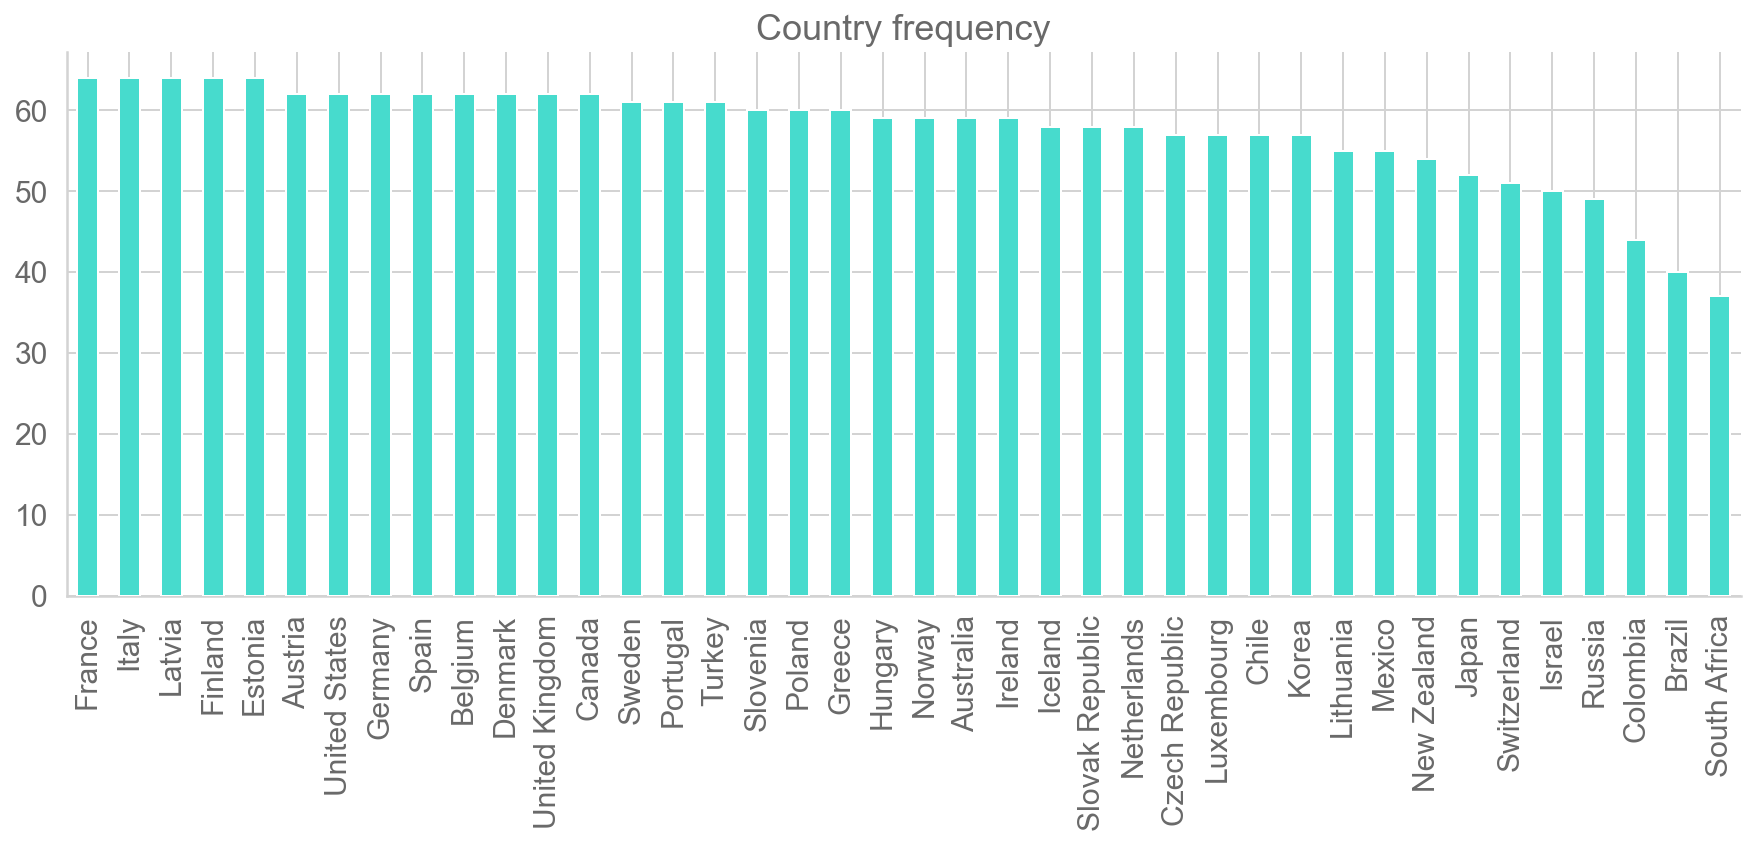

In [8]:
df_bli["country"].value_counts(dropna=False).plot.bar(figsize=(15, 5), color="#47DBCD", zorder=10)
plt.title("Country frequency");

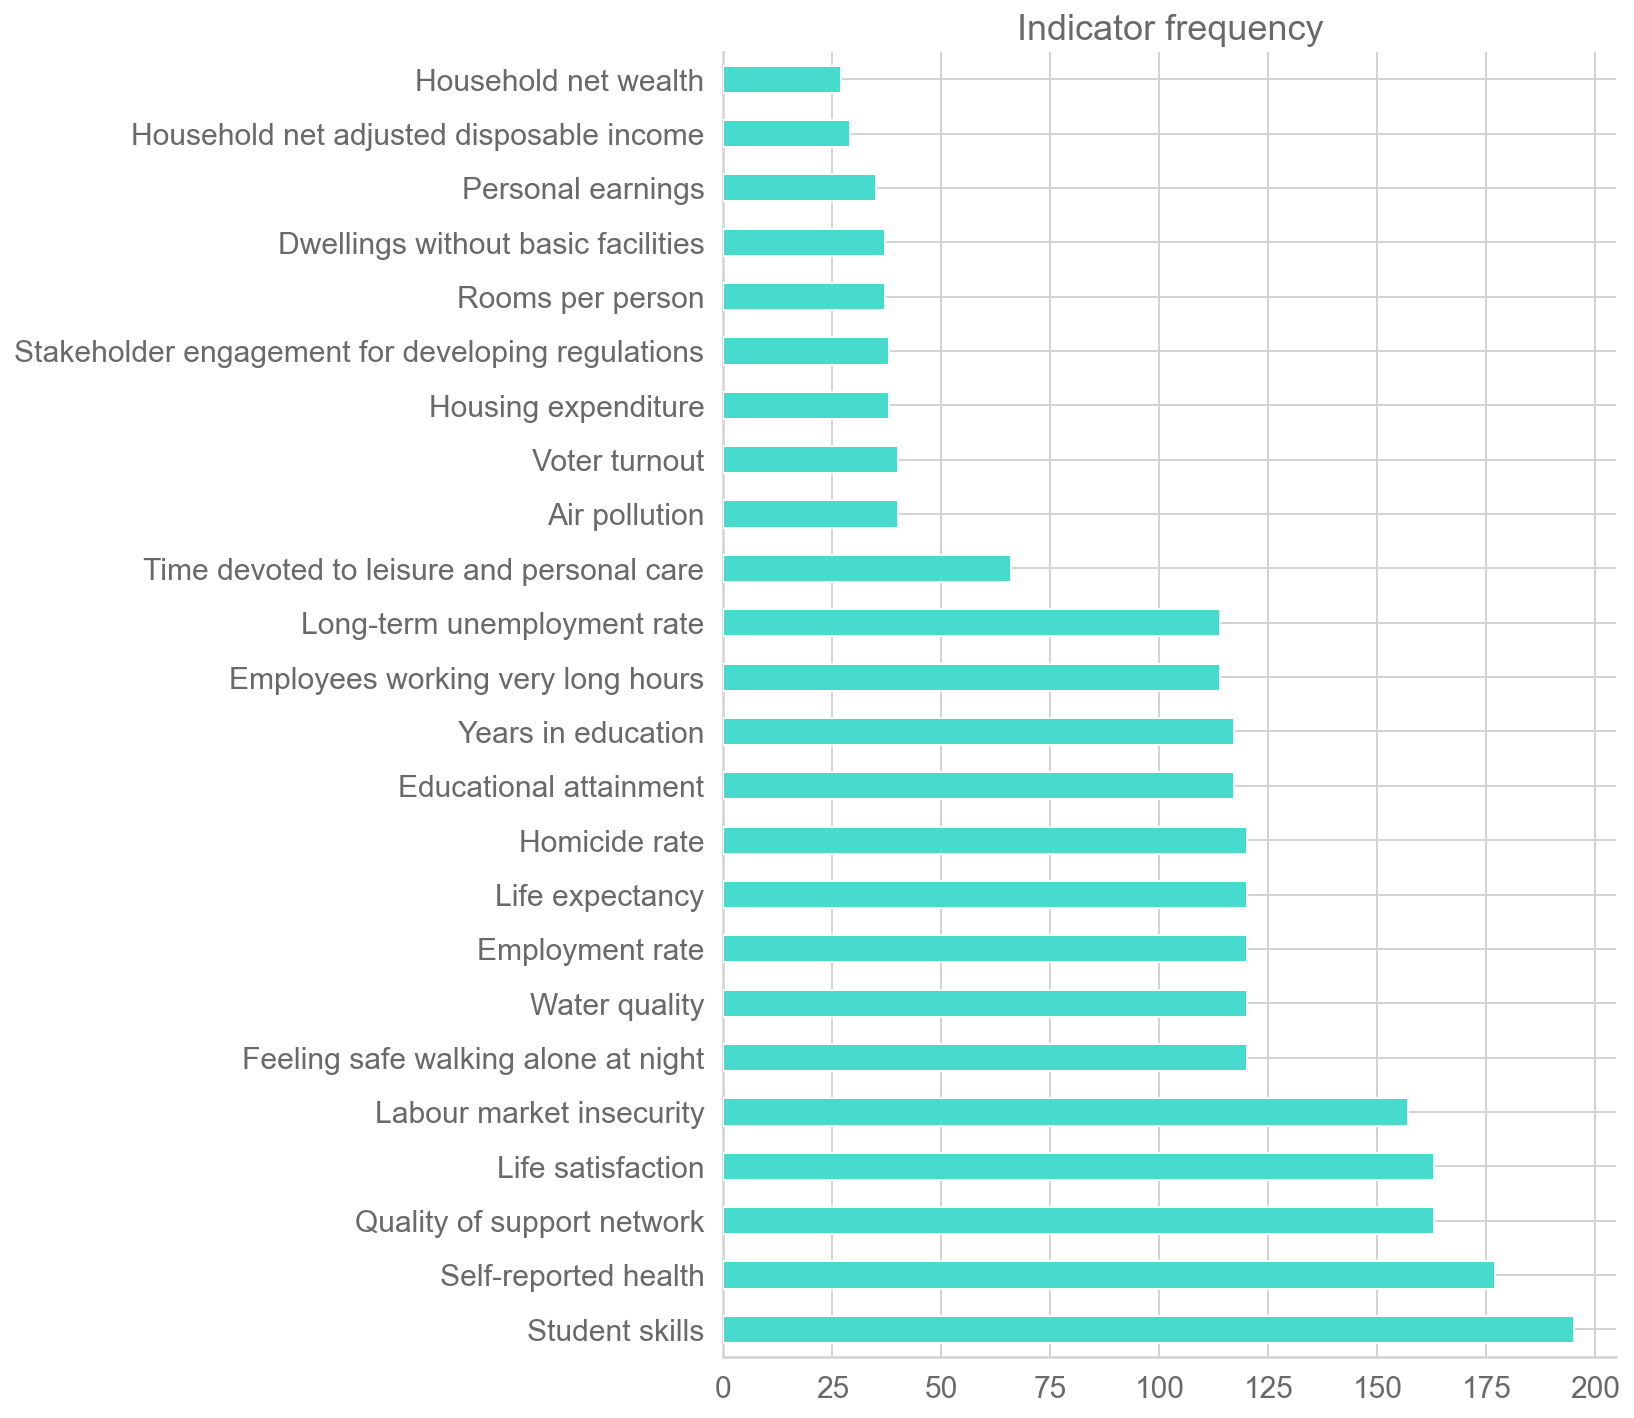

In [9]:
df_bli["indicator"].value_counts(dropna=False).plot.barh(figsize=(8, 12), color="#47DBCD", zorder=10)
plt.title("Indicator frequency");

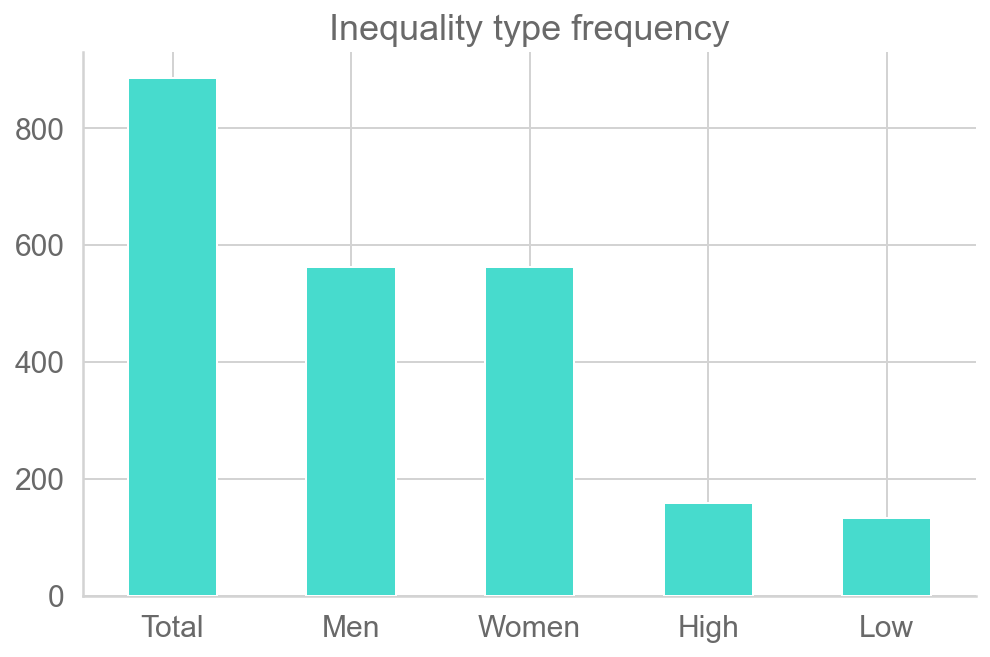

In [10]:
df_bli["inequality"].value_counts(dropna=False).plot.bar(figsize=(8, 5), color="#47DBCD", zorder=10)
plt.title("Inequality type frequency")
plt.xticks(rotation="horizontal");

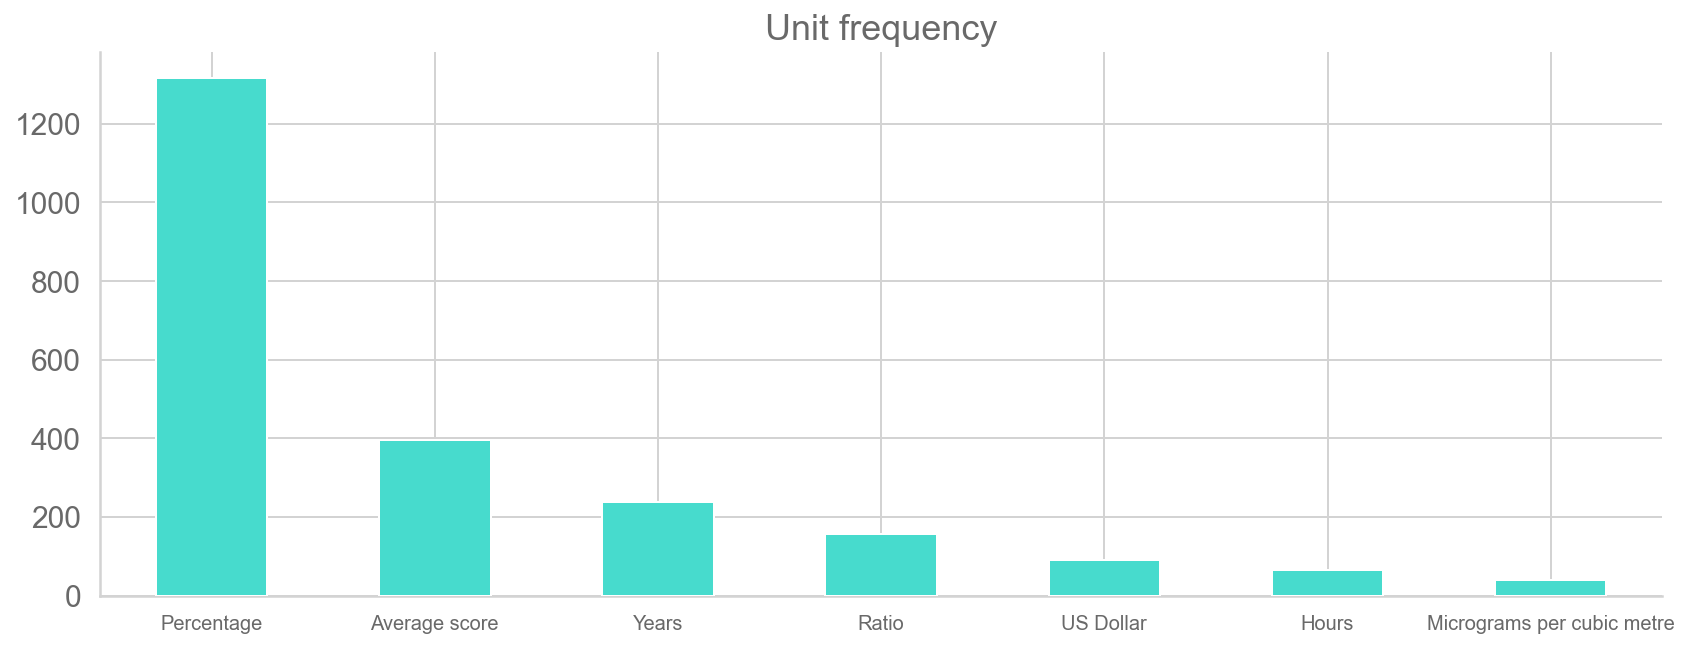

In [11]:
df_bli["unit"].value_counts(dropna=False).plot.bar(figsize=(14, 5), color="#47DBCD", zorder=10)
plt.title("Unit frequency")
plt.xticks(rotation=0, fontsize=10);

In [12]:
(df_bli[df_bli["inequality"] == "Total"]
 .groupby("indicator")
 .agg({"value": ["min", "median", "mean", "max", "mad"]})["value"])

,min,median,mean,max,mad
indicator,,,,,
Air pollution,3.00,14.00,13.325000,28.00,4.708750
Dwellings without basic facilities,0.00,0.90,5.075676,37.00,5.965814
Educational attainment,38.00,82.00,77.769231,94.00,11.333333
Employees working very long hours,0.14,5.00,7.951316,32.64,5.815485
Employment rate,43.00,69.50,68.475000,86.00,5.827500
Feeling safe walking alone at night,35.60,70.30,68.250000,90.10,11.112500
Homicide rate,0.20,0.95,3.430000,26.70,3.983000
Household net adjusted disposable income,16275.00,29333.00,27807.310345,45284.00,5835.864447
Household net wealth,70160.00,259667.00,289780.185185,769053.00,123327.936900


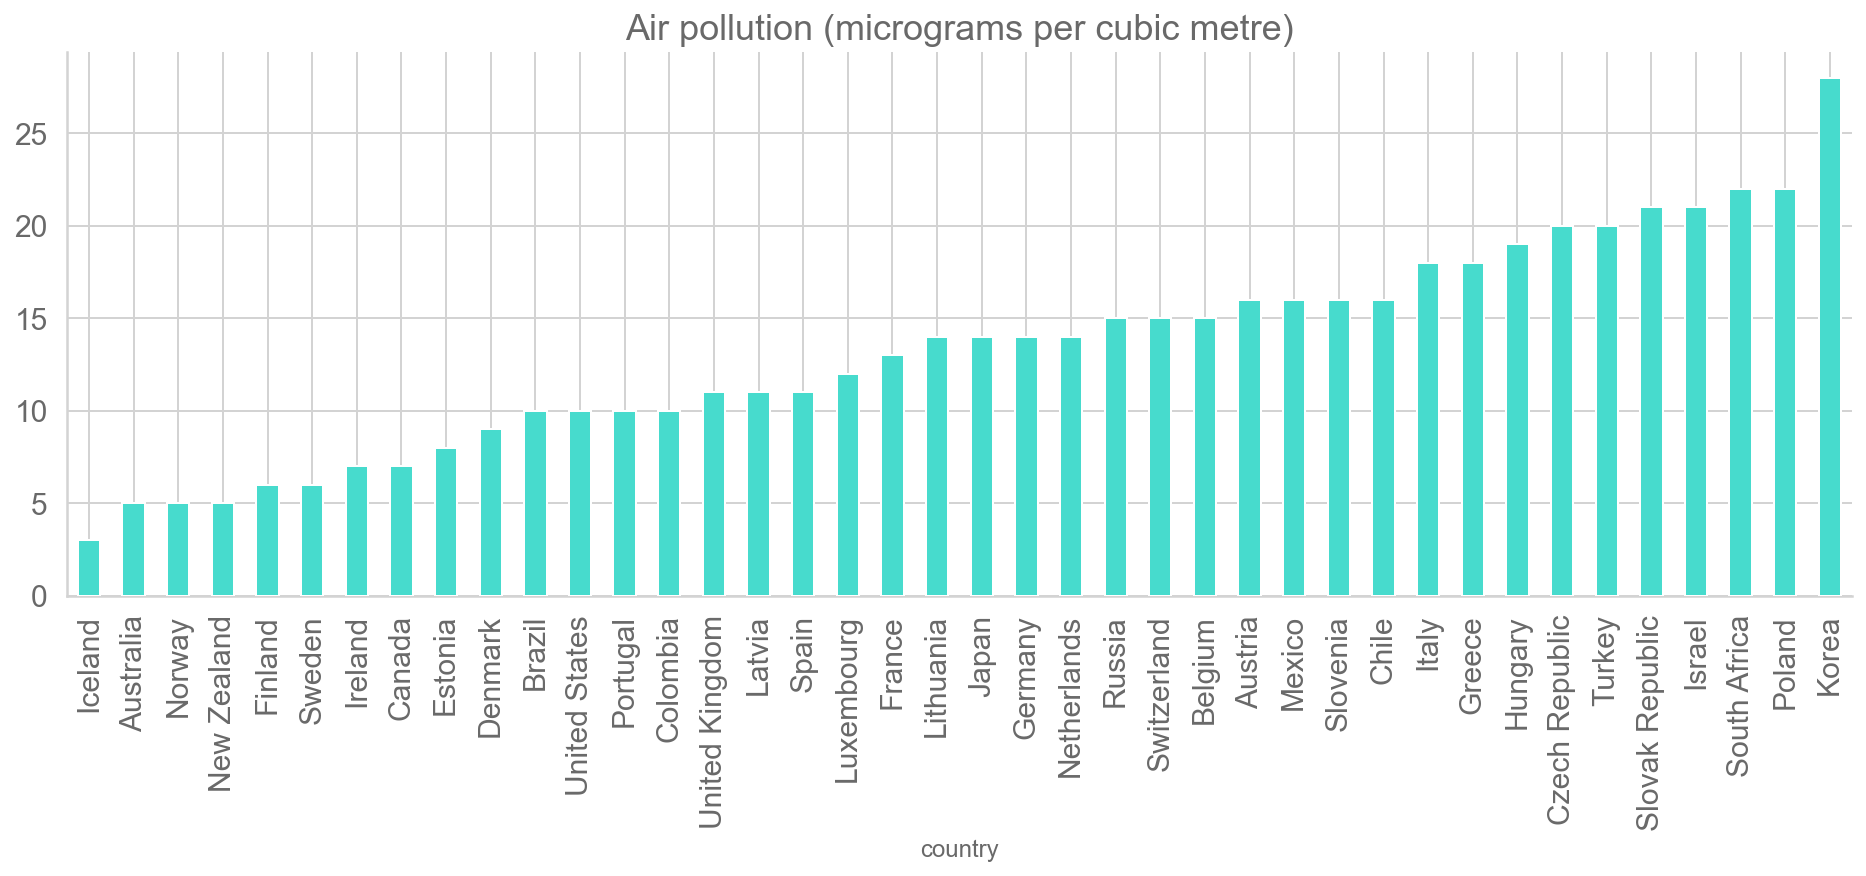

In [13]:
(df_bli[df_bli["indicator"] == "Air pollution"]
 .set_index("country")["value"]
 .sort_values()
 .plot.bar(figsize=(16, 5), color="#47DBCD", zorder=10))
plt.title("Air pollution (micrograms per cubic metre)");

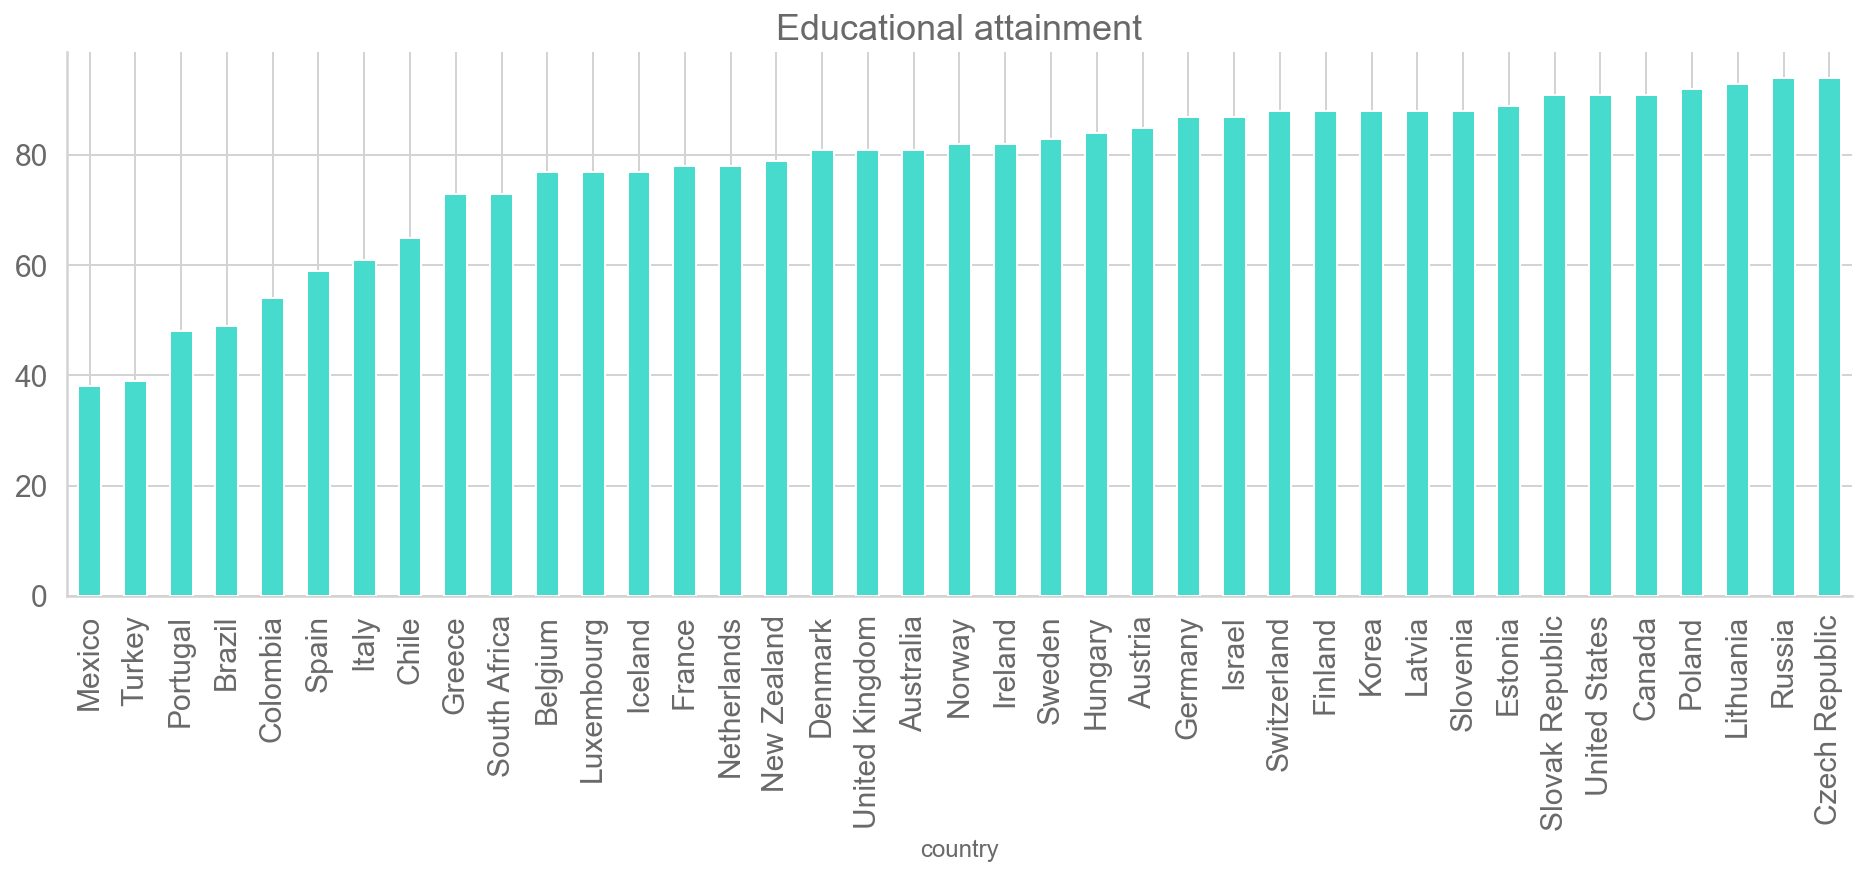

In [14]:
((df_bli[df_bli["indicator"] == "Educational attainment"])
 .query("inequality == 'Total'")
 .set_index("country")["value"]
 .sort_values()
 .plot.bar(figsize=(16, 5), color="#47DBCD", zorder=10))
plt.title("Educational attainment");

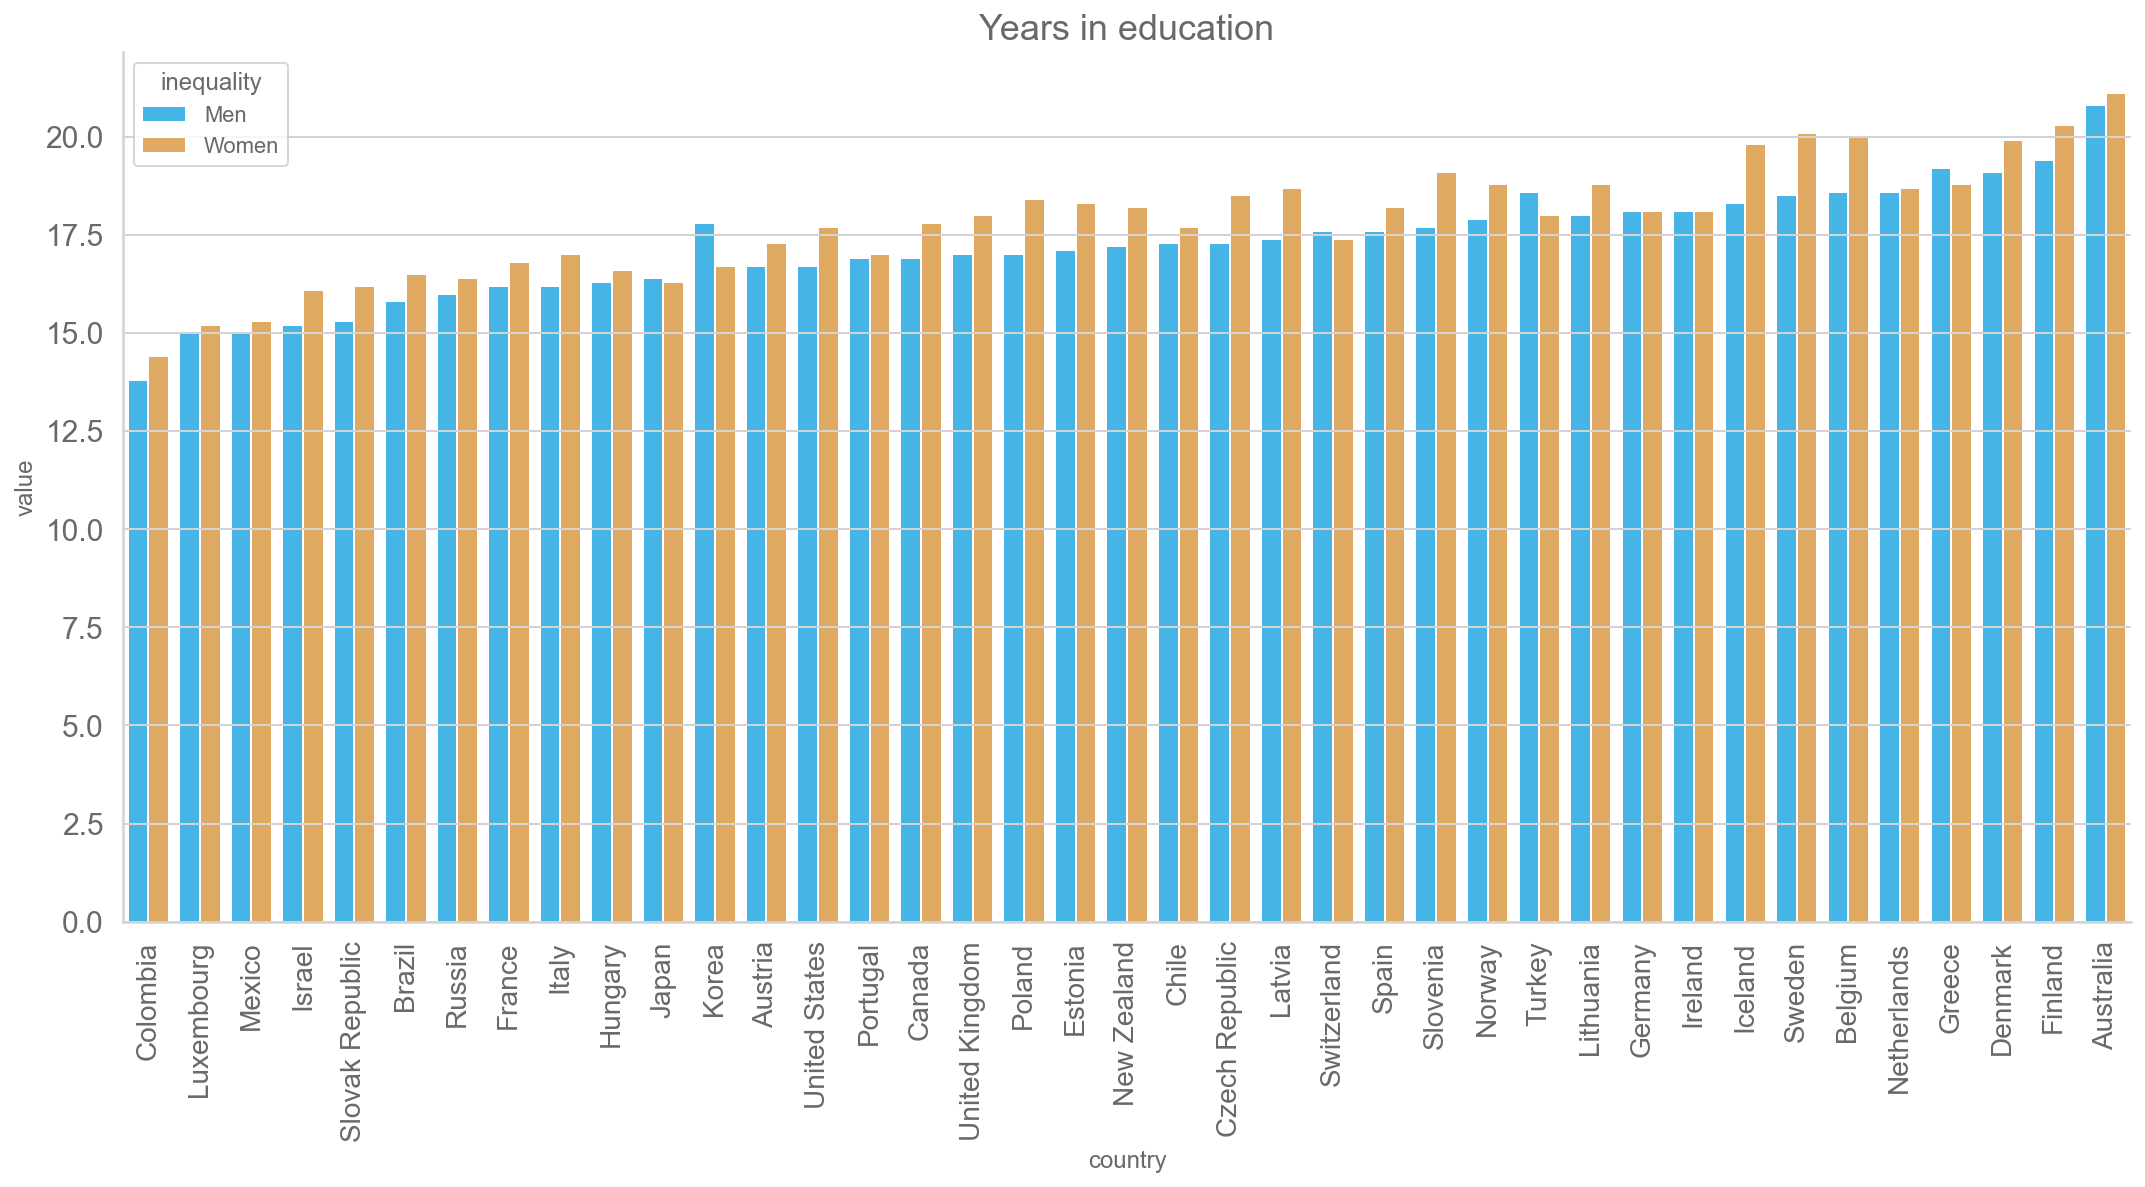

In [15]:
plt.figure(figsize=(18, 8))
sns.barplot(
    x="country",
    y="value",
    hue="inequality",
    data=((df_bli[df_bli["indicator"] == "Years in education"])
           .query("inequality != 'Total'")
           .sort_values(by="value")),
    palette=["#2CBFFF", "#F5AC4C"]
)
plt.title("Years in education")
plt.xticks(rotation="vertical", fontsize=14);

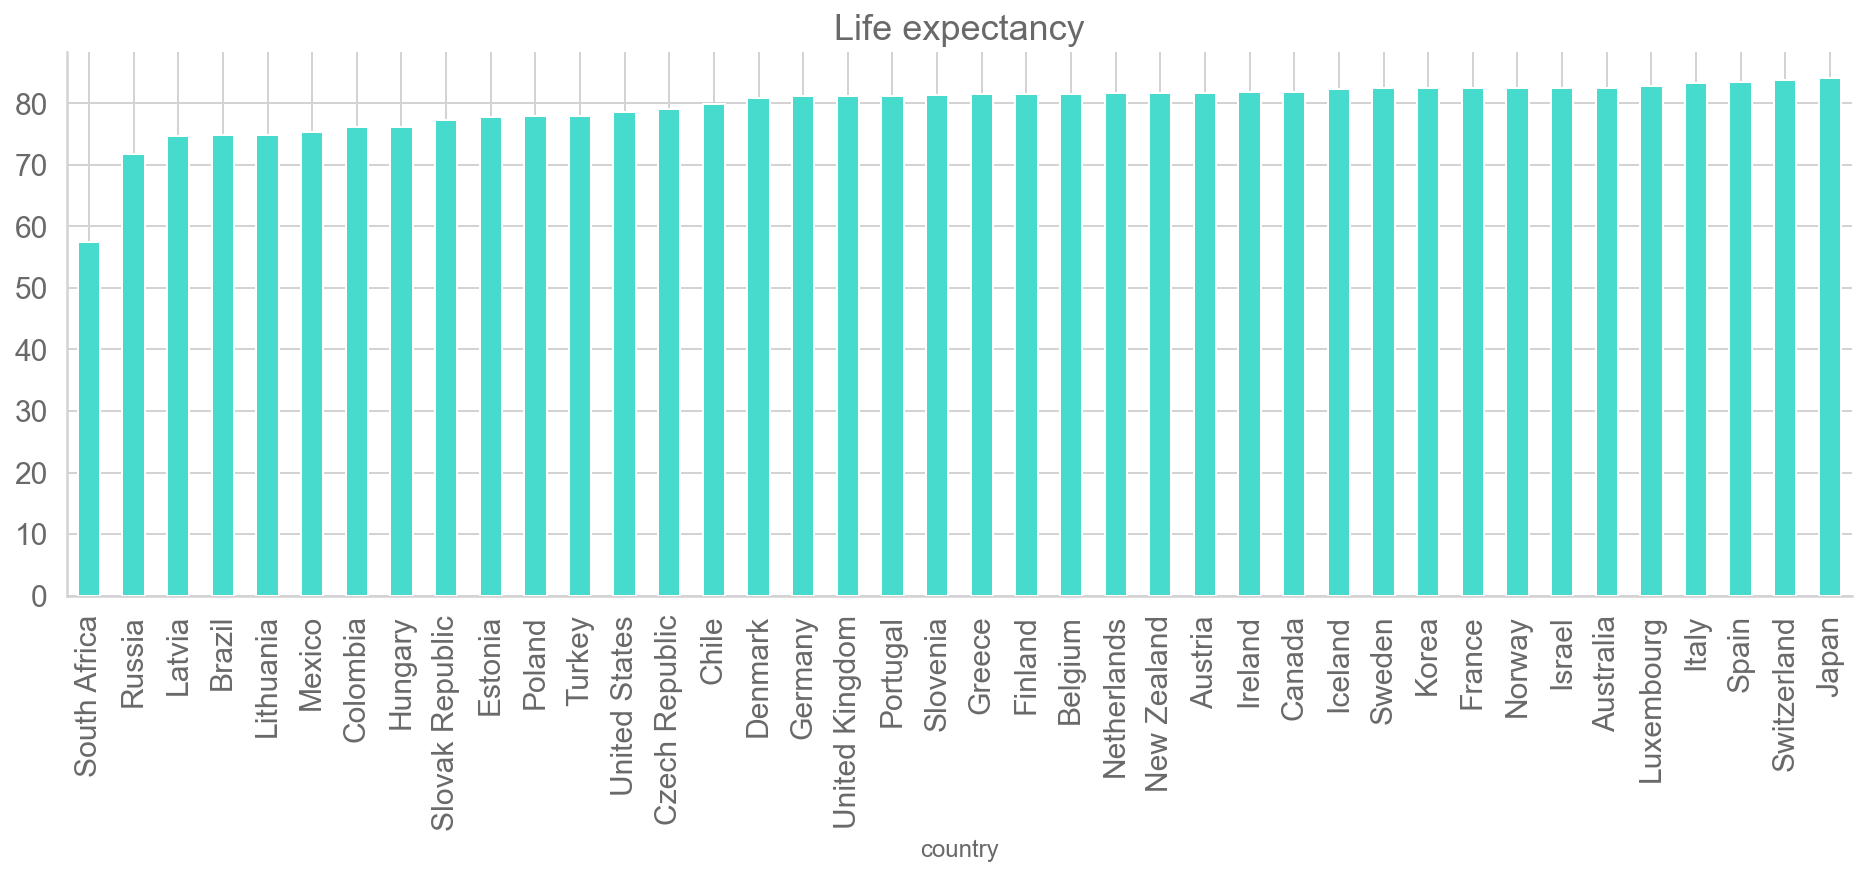

In [16]:
((df_bli[df_bli["indicator"] == "Life expectancy"])
 .query("inequality == 'Total'")
 .set_index("country")["value"]
 .sort_values()
 .plot.bar(figsize=(16, 5), color="#47DBCD", zorder=10))
plt.title("Life expectancy");

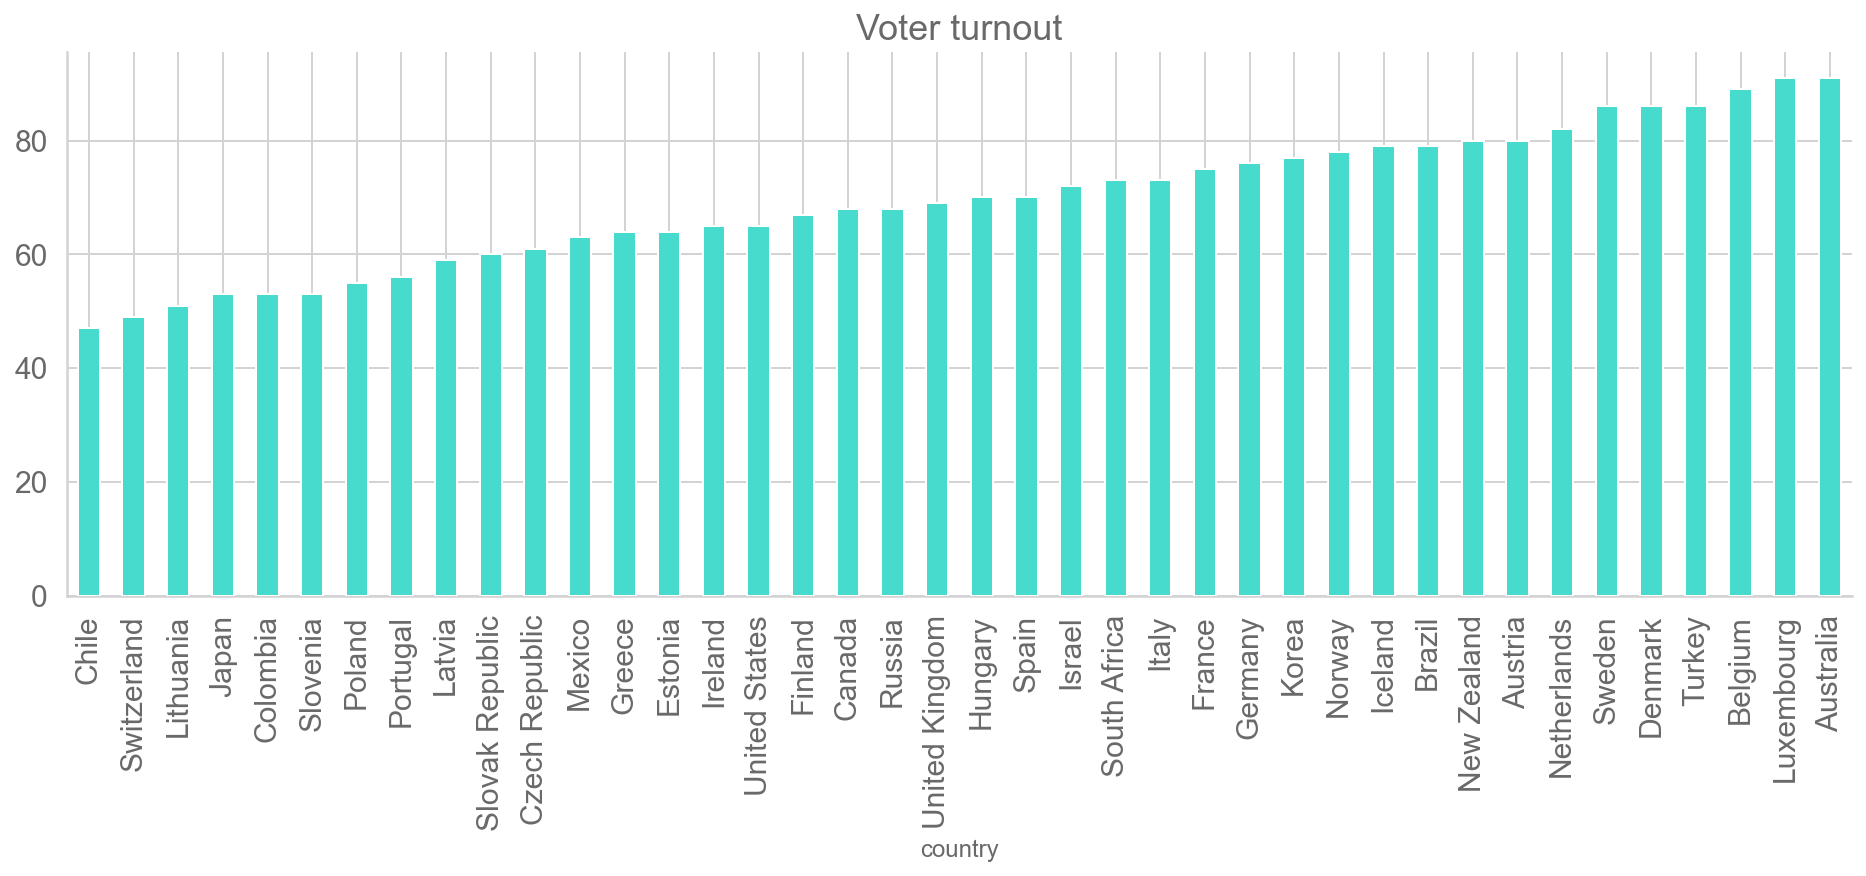

In [17]:
((df_bli[df_bli["indicator"] == "Voter turnout"])
 .query("inequality == 'Total'")
 .set_index("country")["value"]
 .sort_values()
 .plot.bar(figsize=(16, 5), color="#47DBCD", zorder=10))
plt.title("Voter turnout");

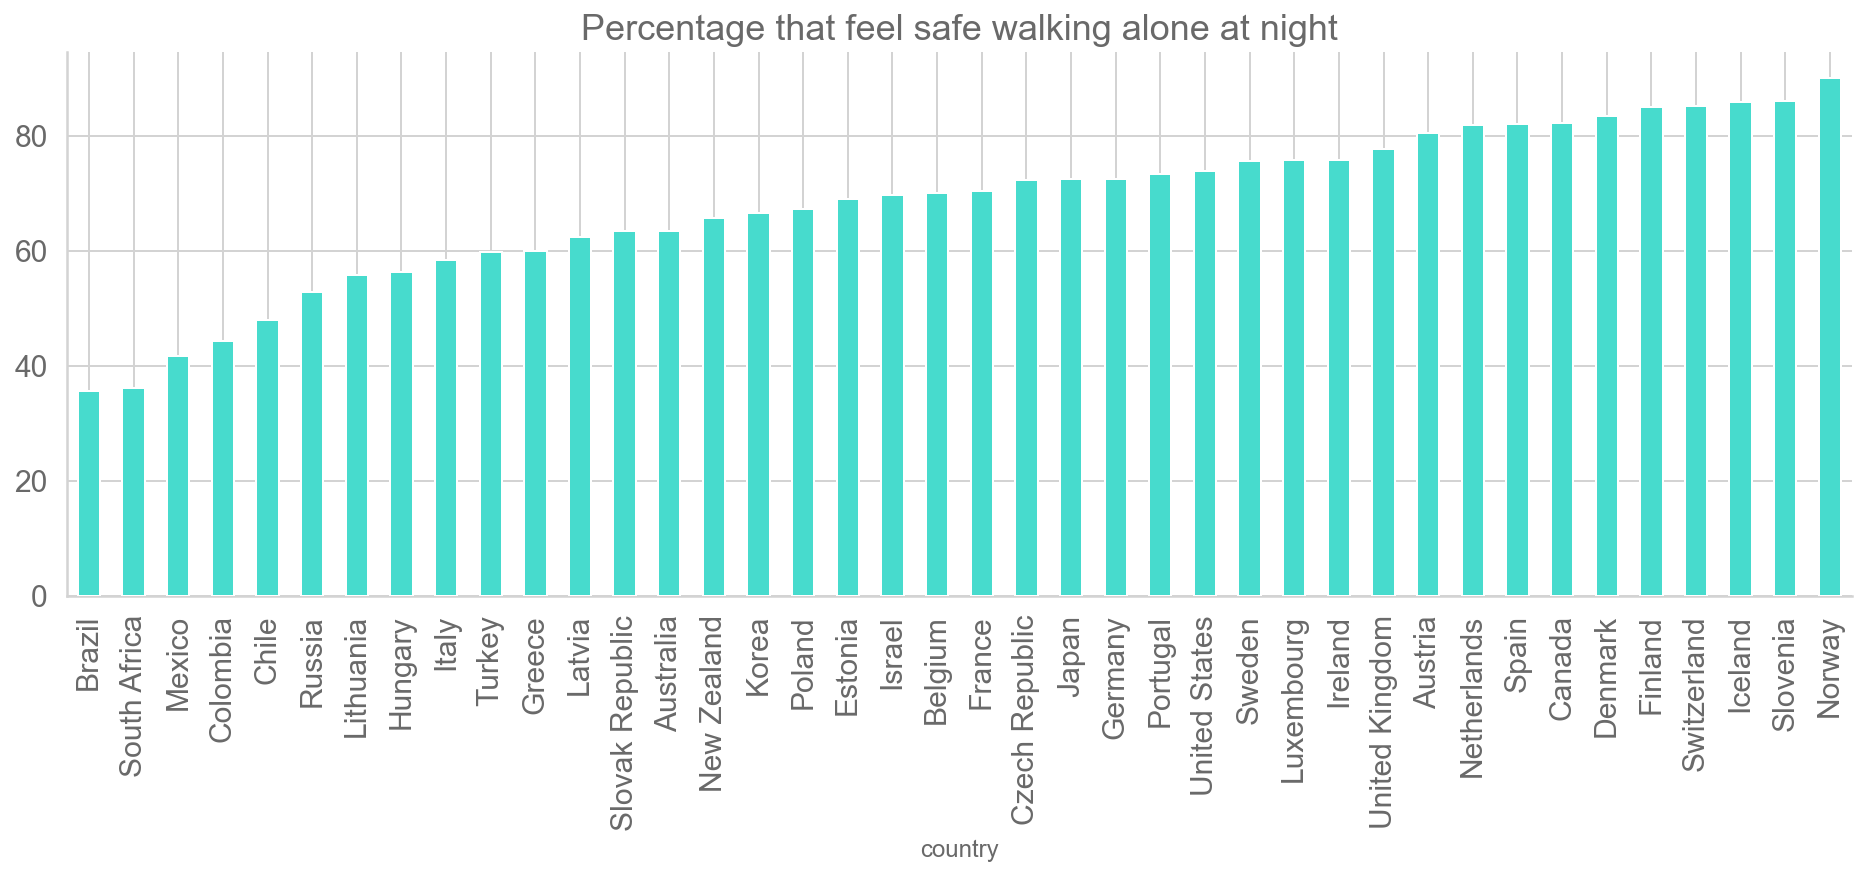

In [18]:
((df_bli[df_bli["indicator"] == "Feeling safe walking alone at night"])
 .query("inequality == 'Total'")
 .set_index("country")["value"]
 .sort_values()
 .plot.bar(figsize=(16, 5), color="#47DBCD", zorder=10))
plt.title("Percentage that feel safe walking alone at night");

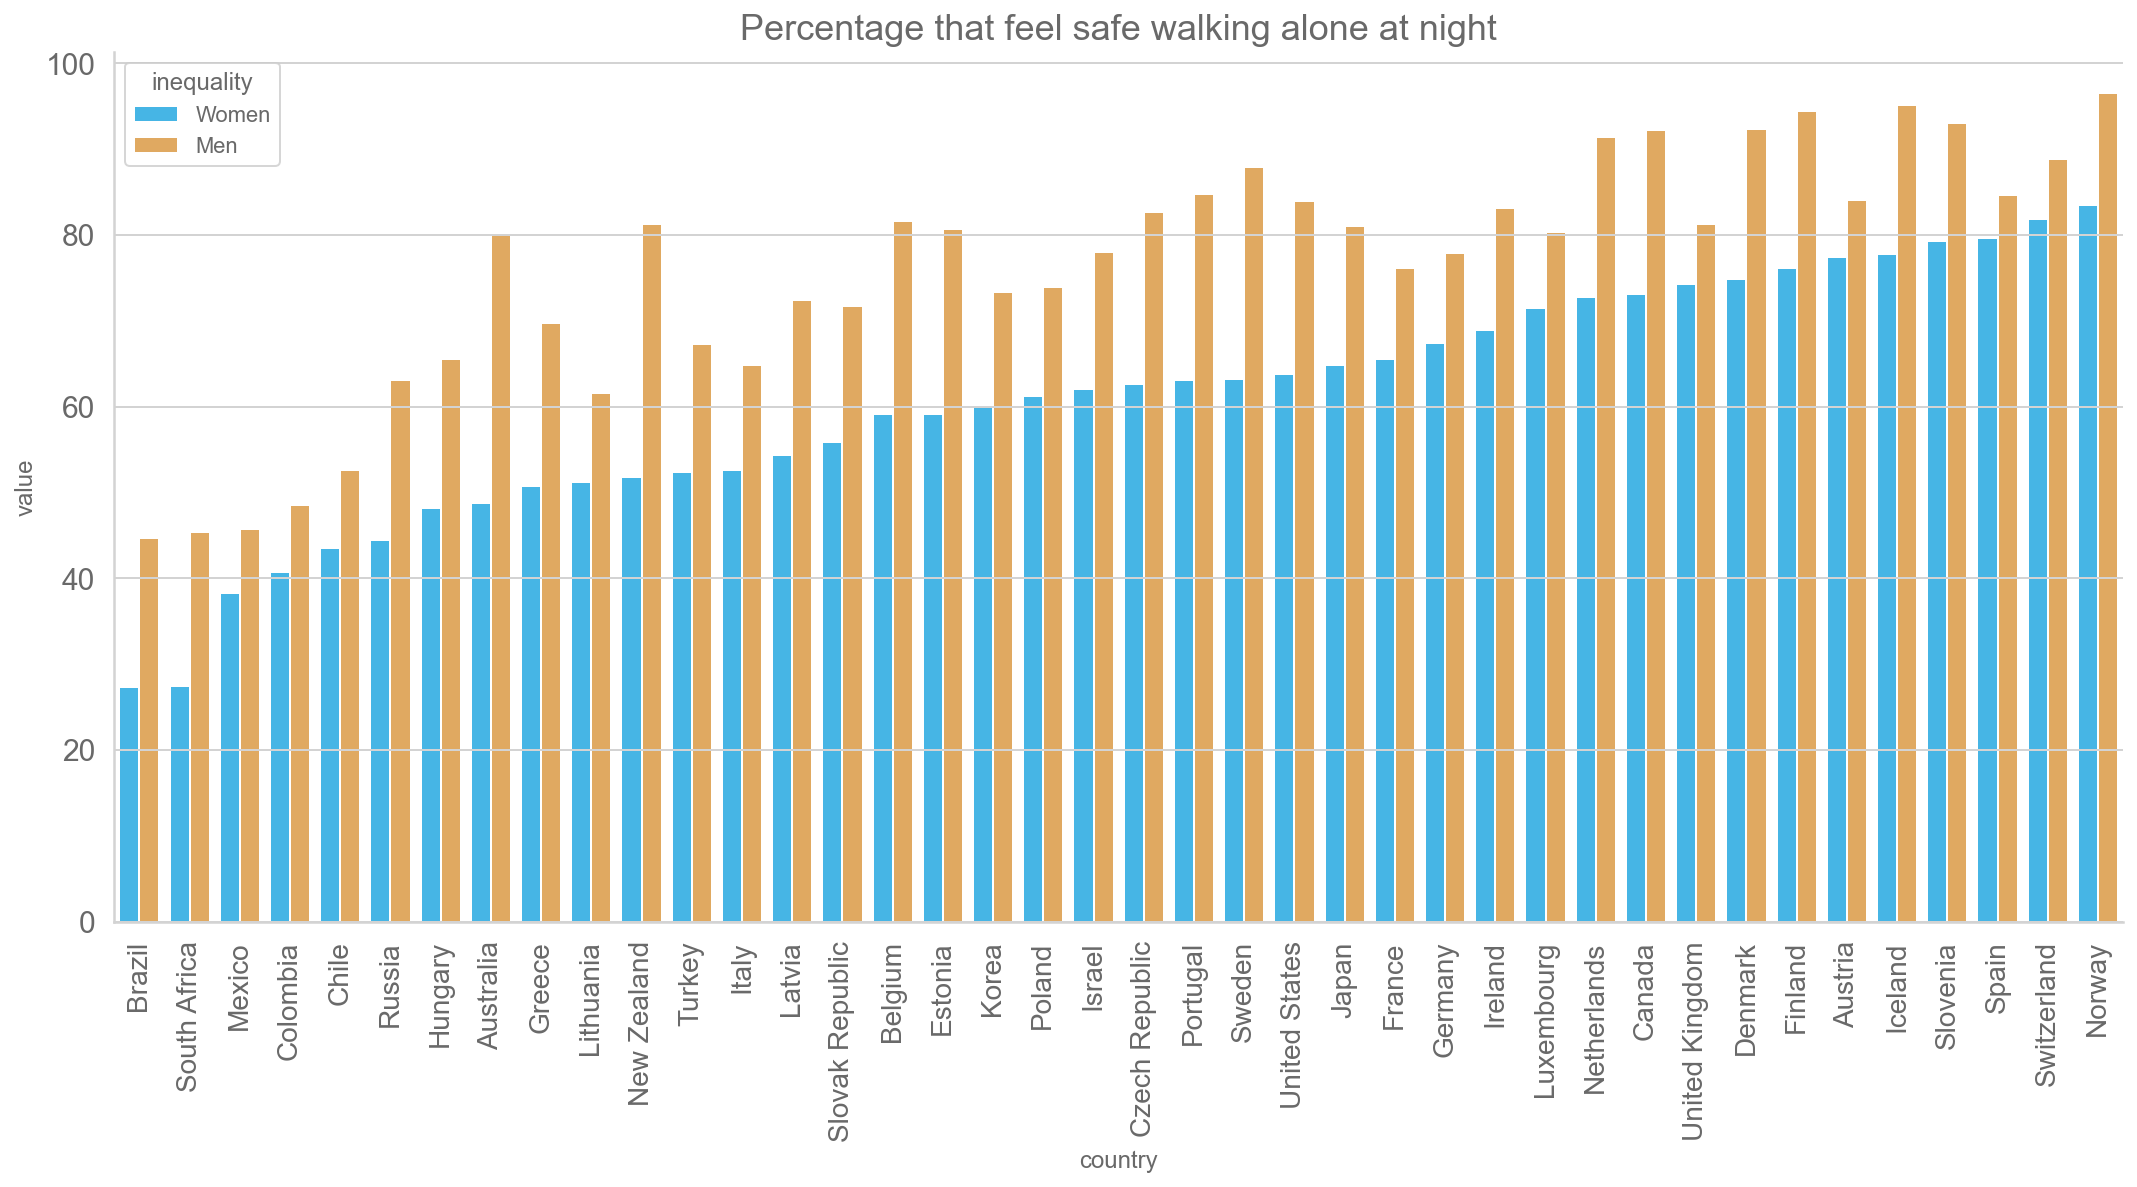

In [19]:
plt.figure(figsize=(18, 8))
sns.barplot(
    x="country",
    y="value",
    hue="inequality",
    data=((df_bli[df_bli["indicator"] == "Feeling safe walking alone at night"])
           .query("inequality != 'Total'")
           .sort_values(by="value")),
    palette=["#2CBFFF", "#F5AC4C"]
)
plt.title("Percentage that feel safe walking alone at night")
plt.xticks(rotation="vertical", fontsize=14);

# Exploring GDP data

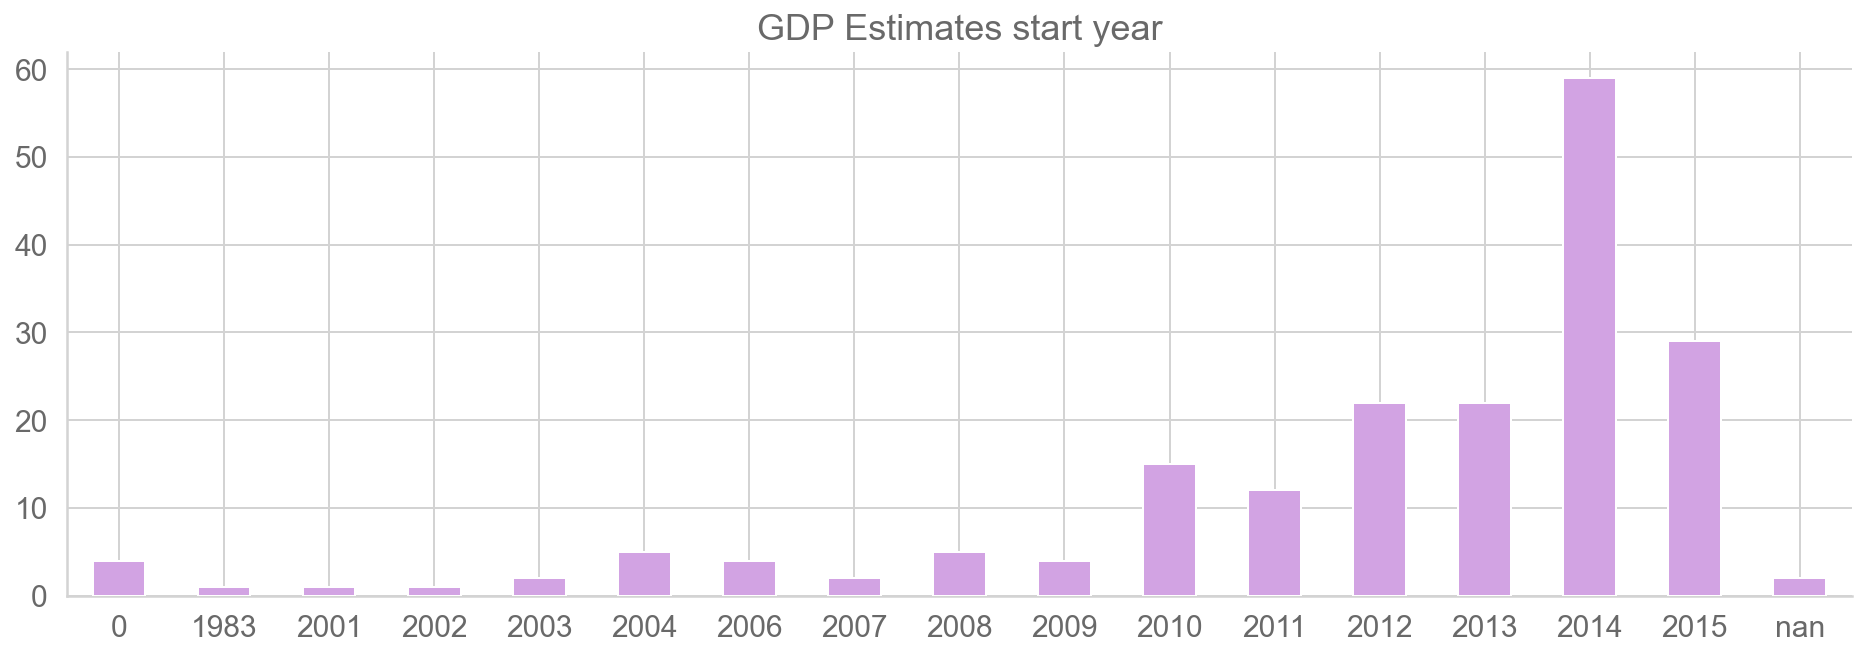

In [20]:
(df_gdp["estimates_start_time"]
 .astype(str)
 .apply(lambda s: s[:-2] if s.endswith(".0") else s)
 .value_counts(dropna=False)
 .sort_index()
 .plot.bar(figsize=(16, 5), color="#D2A3E3", zorder=10))
plt.xticks(rotation="horizontal")
plt.title("GDP Estimates start year");

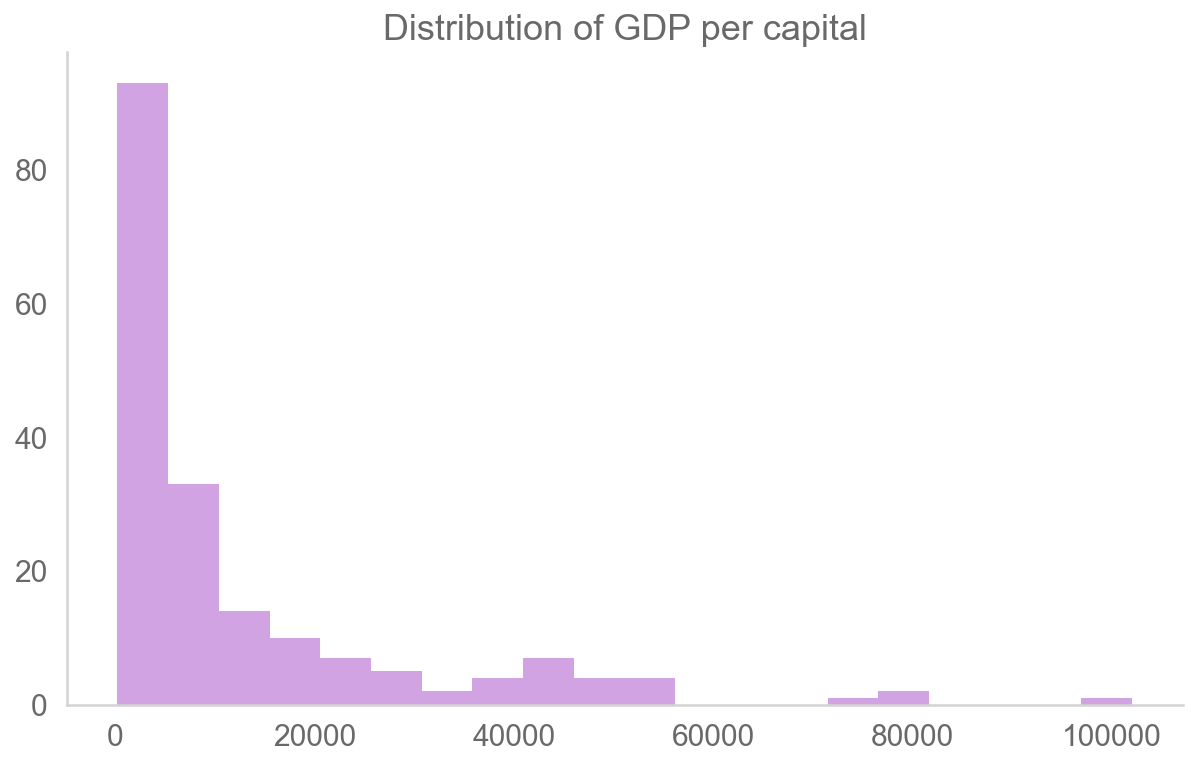

In [21]:
df_gdp["gdp_per_capita"].hist(figsize=(10, 6), bins=20, color="#D2A3E3", ec="none", grid=None)
plt.title("Distribution of GDP per capital");

In [22]:
df_gdp["country"].is_unique

True

In [23]:
print(len(set(df_gdp["country"].str.lower()) - set(df_bli["country"].str.lower())))
print(len(set(df_bli["country"].str.lower()) - set(df_gdp["country"].str.lower())))

150
0


## Restructuring and joining the datasets

In [24]:
df_bli = df_bli[df_bli["inequality"] == "Total"]
df_bli = df_bli.pivot(index="country", columns="indicator", values="value")
df = df_bli.merge(df_gdp, left_on="country", right_on="country")

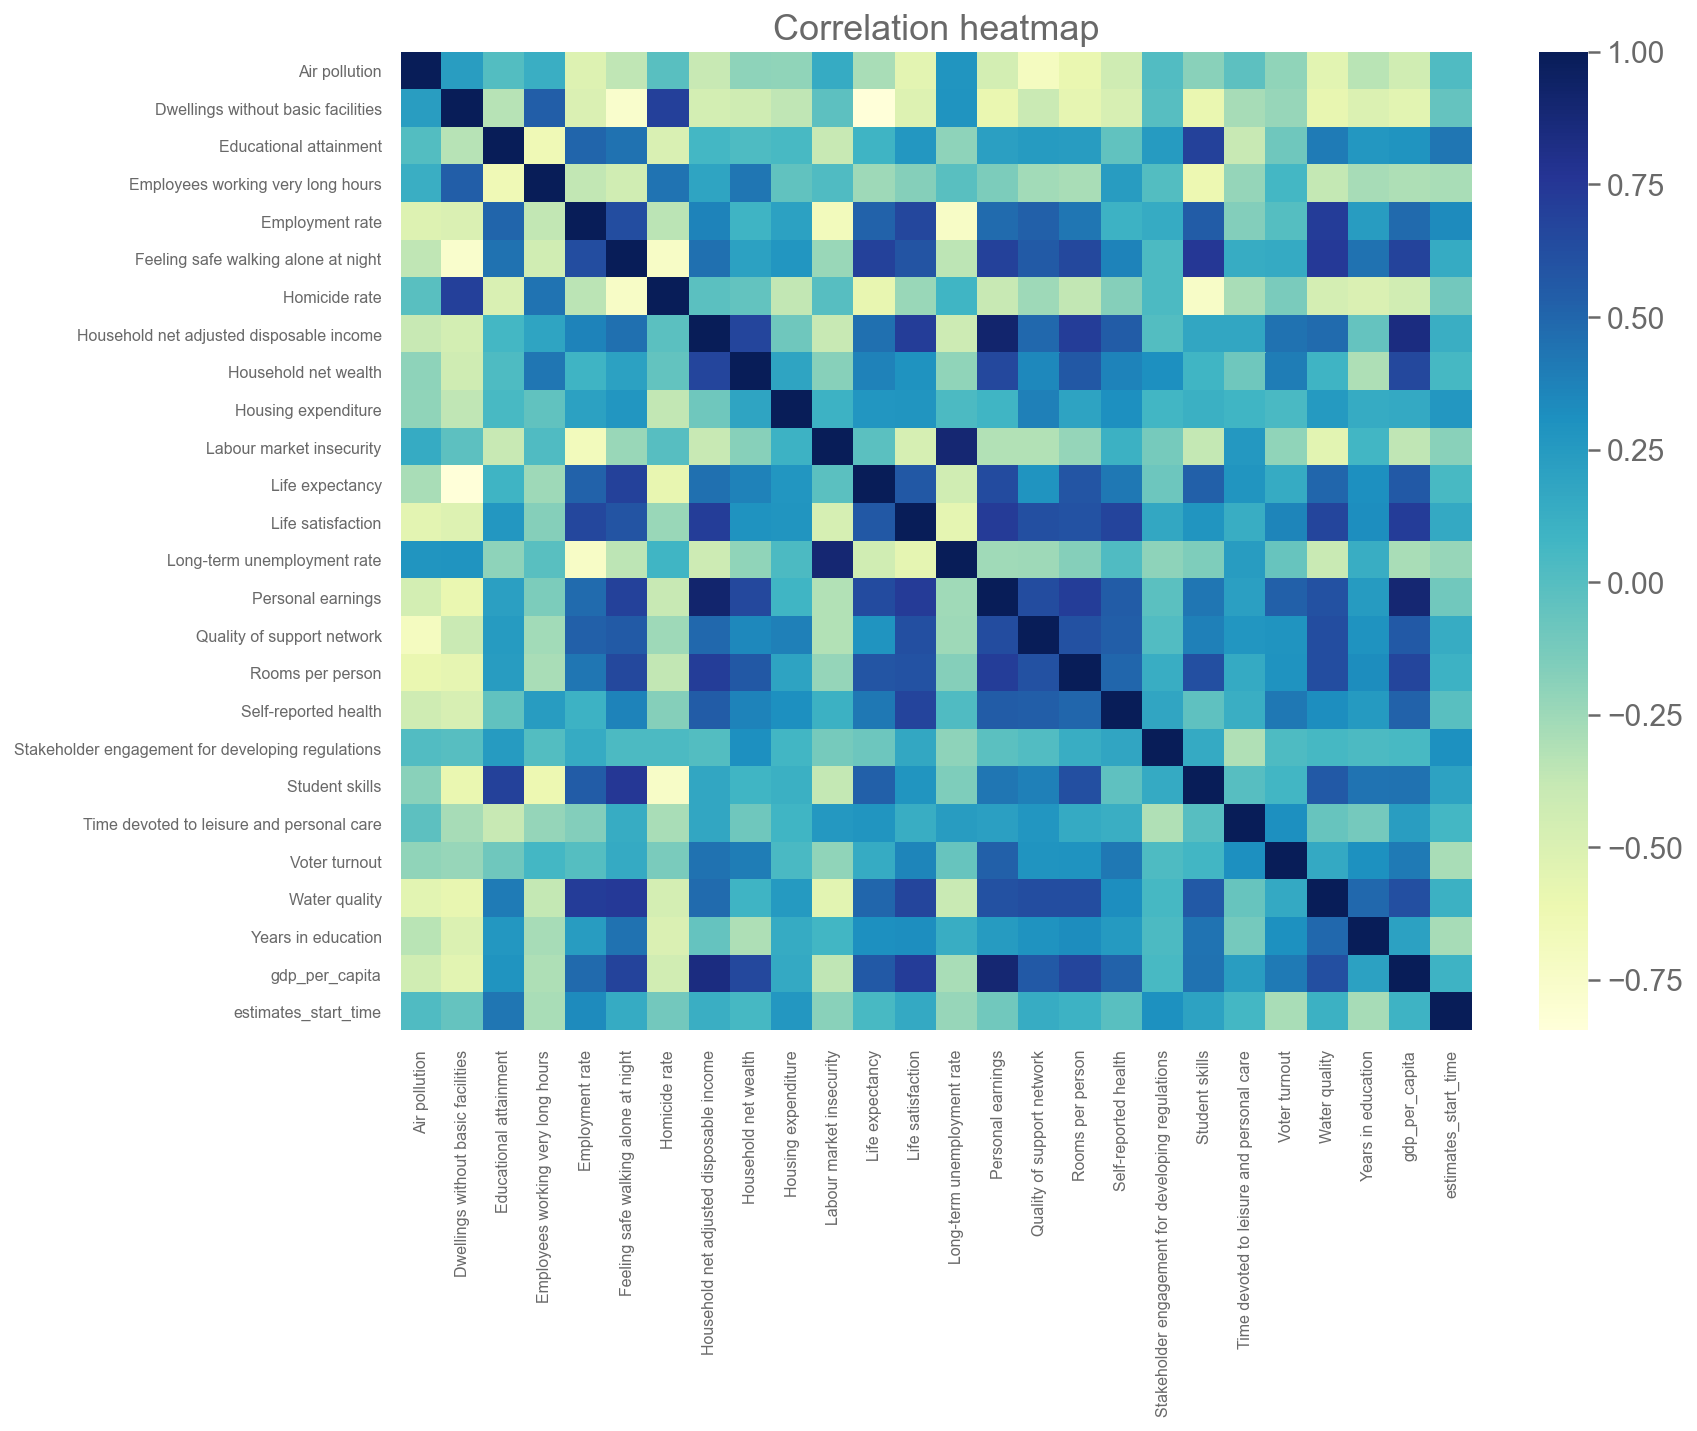

In [25]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), cmap="YlGnBu")
plt.title("Correlation heatmap");
plt.xticks(rotation="vertical", fontsize=8);
plt.yticks(rotation="horizontal", fontsize=8);

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Air pollution,40.0,13.325000,5.770782,3.000,9.75000,14.000,16.50000,28.000
Dwellings without basic facilities,37.0,5.075676,8.448320,0.000,0.30000,0.900,6.70000,37.000
Educational attainment,39.0,77.769231,15.131810,38.000,75.00000,82.000,88.00000,94.000
Employees working very long hours,38.0,7.951316,7.872469,0.140,3.19500,5.000,10.74750,32.640
Employment rate,40.0,68.475000,7.971061,43.000,65.75000,69.500,74.00000,86.000
Feeling safe walking alone at night,40.0,68.250000,14.023570,35.600,59.95000,70.300,78.42500,90.100
Homicide rate,40.0,3.430000,6.334003,0.200,0.60000,0.950,2.12500,26.700
Household net adjusted disposable income,29.0,27807.310345,7055.262661,16275.000,21453.00000,29333.000,31304.00000,45284.000
Household net wealth,27.0,289780.185185,165673.432787,70160.000,180100.00000,259667.000,379777.00000,769053.000
Housing expenditure,38.0,20.657895,2.528500,15.000,19.00000,21.000,22.75000,26.000


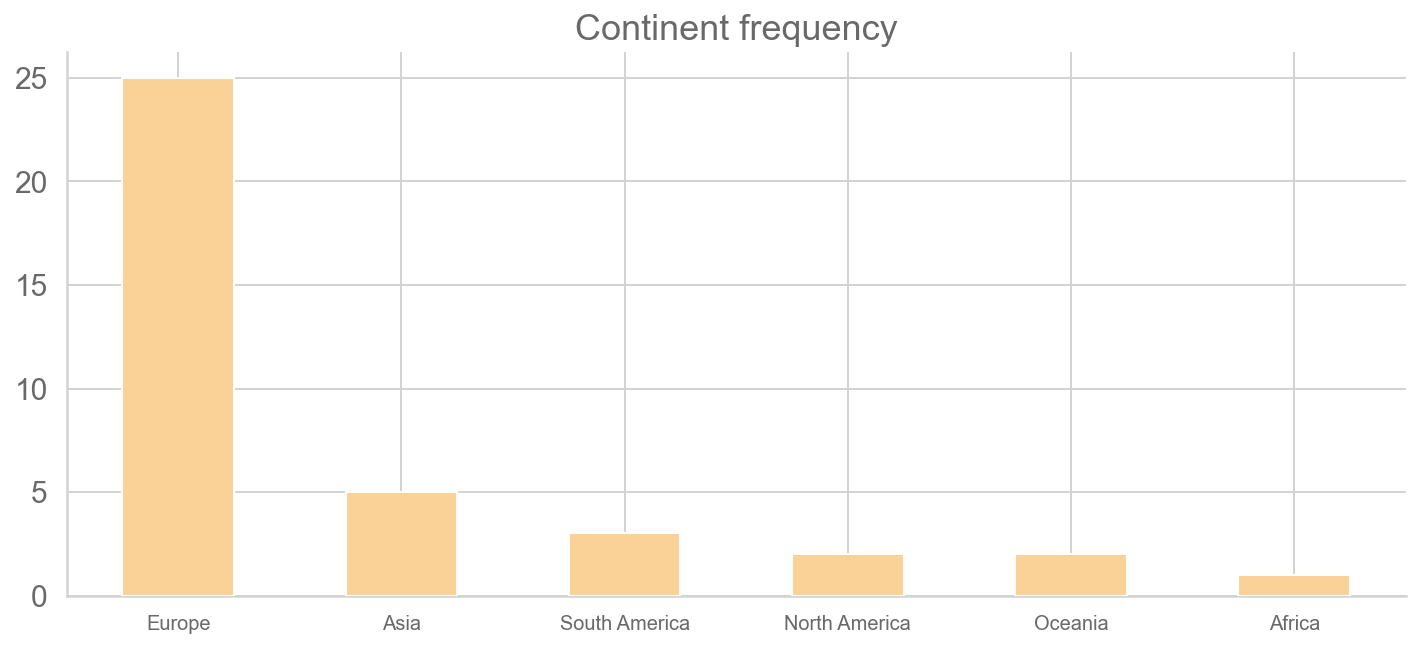

In [27]:
continents = pd.read_csv("./data/country_continent",
                         usecols=["Continent_Name", "Country_Name"])
continents.rename(columns={"Continent_Name": "continent", "Country_Name": "country"}, inplace=True)
continents["country"] = (continents["country"]
                         .apply(lambda x: x.split(",")[0])
                         .apply(lambda x: x.split("(")[0])
                         .str.strip())
df = df.merge(continents, left_on="country", right_on="country")
df["continent"].value_counts(dropna=False).plot.bar(figsize=(12, 5), color="#FAD196", zorder=10)
plt.title("Continent frequency")
plt.xticks(rotation=0, fontsize=10);

## PCA

In [28]:
def generate_principal_components(kernel):
    pca = KernelPCA(n_components=2, kernel=kernel)
    principal_components = pca.fit_transform(transformed_features)
    principal_components = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
    principal_components = pd.concat([principal_components, df[["continent"]]], axis="columns")
    return principal_components

In [29]:
feature_names = df.select_dtypes("float").columns.to_list()
features = df.loc[:, feature_names].fillna(df.mean()).values
transformed_features = StandardScaler().fit_transform(features)

linear_principal_components = generate_principal_components("linear")
poly_principal_components = generate_principal_components("poly")
rbf_principal_components = generate_principal_components("rbf")
sigmoid_principal_components = generate_principal_components("sigmoid")

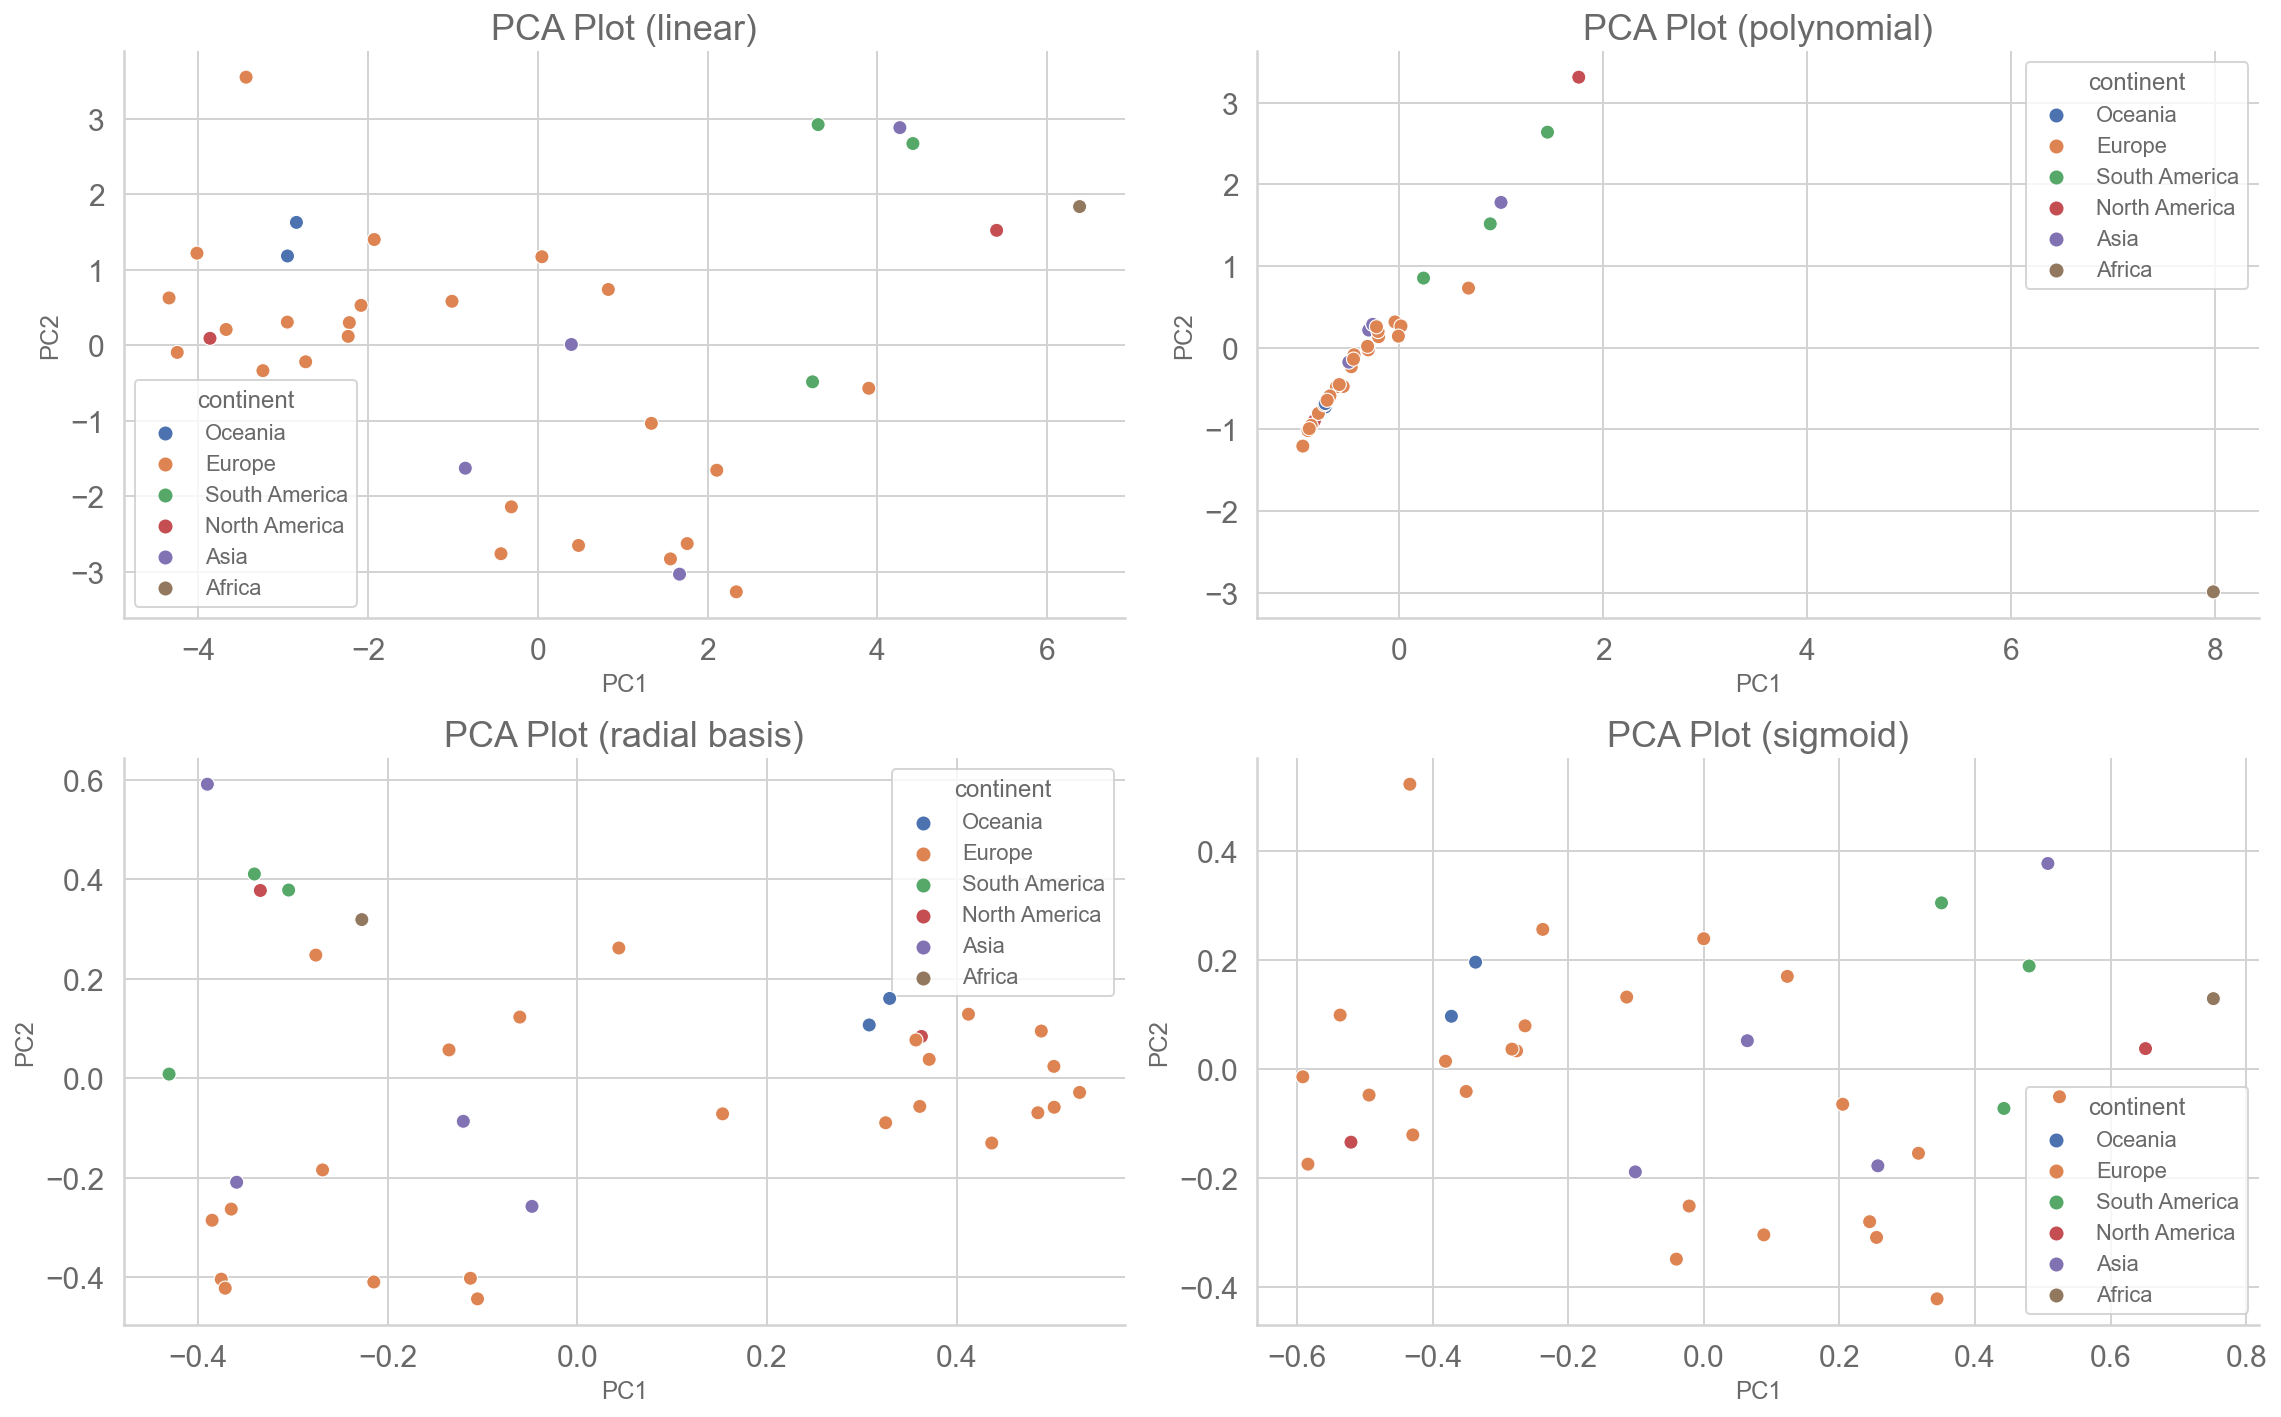

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.scatterplot(data=linear_principal_components,
                x="PC1", y="PC2", hue="continent", s=50, zorder=10, ax=axes[0][0])
axes[0][0].set_title("PCA Plot (linear)")

sns.scatterplot(data=poly_principal_components,
                x="PC1", y="PC2", hue="continent", s=50, zorder=10, ax=axes[0][1])
axes[0][1].set_title("PCA Plot (polynomial)")

sns.scatterplot(data=rbf_principal_components,
                x="PC1", y="PC2", hue="continent", s=50, zorder=10, ax=axes[1][0])
axes[1][0].set_title("PCA Plot (radial basis)")

sns.scatterplot(data=sigmoid_principal_components,
                x="PC1", y="PC2", hue="continent", s=50, zorder=10, ax=axes[1][1])
axes[1][1].set_title("PCA Plot (sigmoid)")

fig.tight_layout()

## Relationship between GDP per capital and life satisfaction

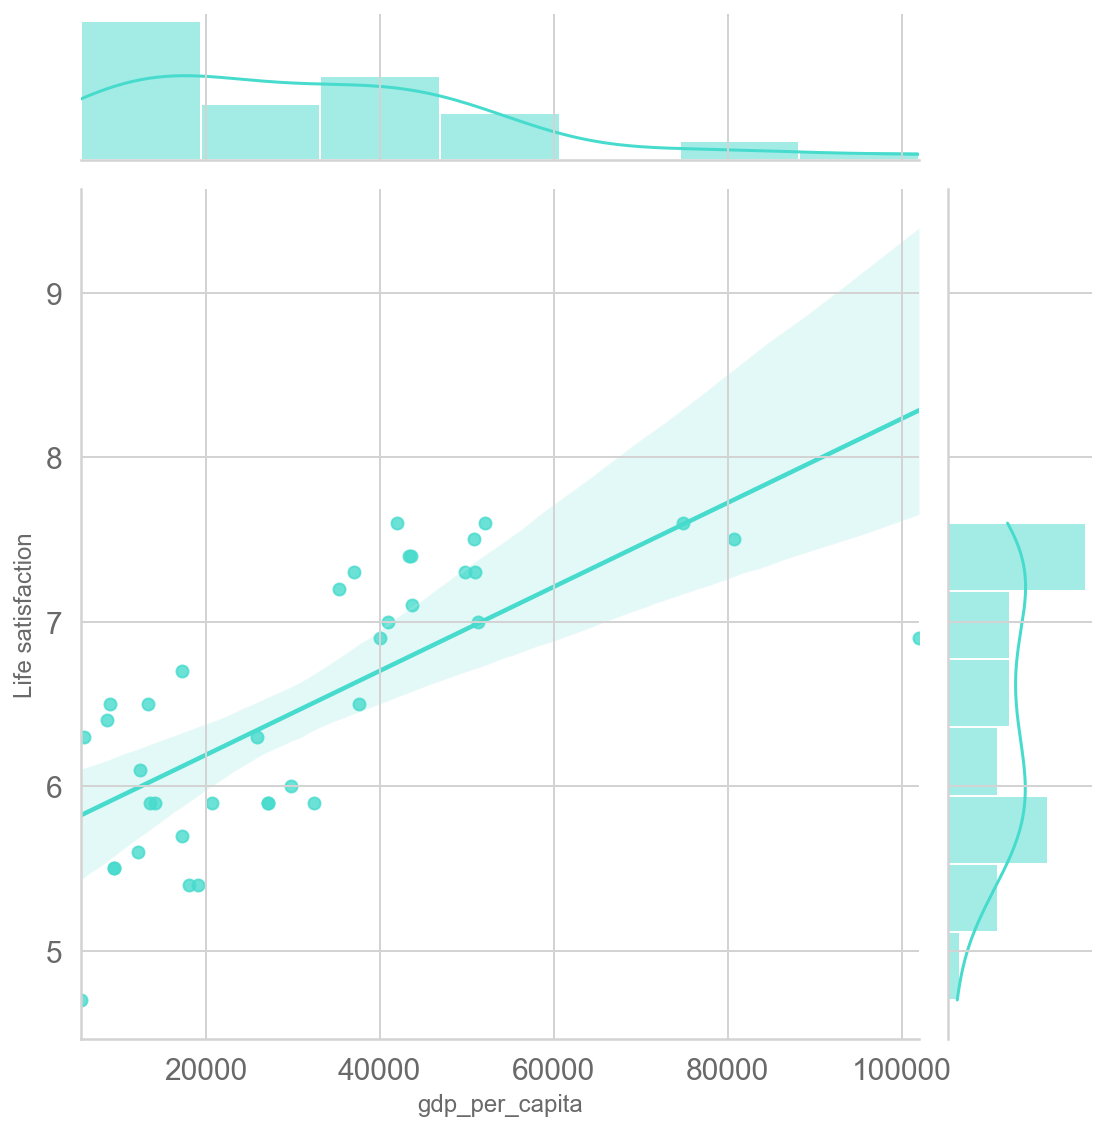

In [31]:
sns.jointplot(x=df['gdp_per_capita'],
              y=df['Life satisfaction'],
              color="#47DBCD",
              kind="reg",
              height=8);

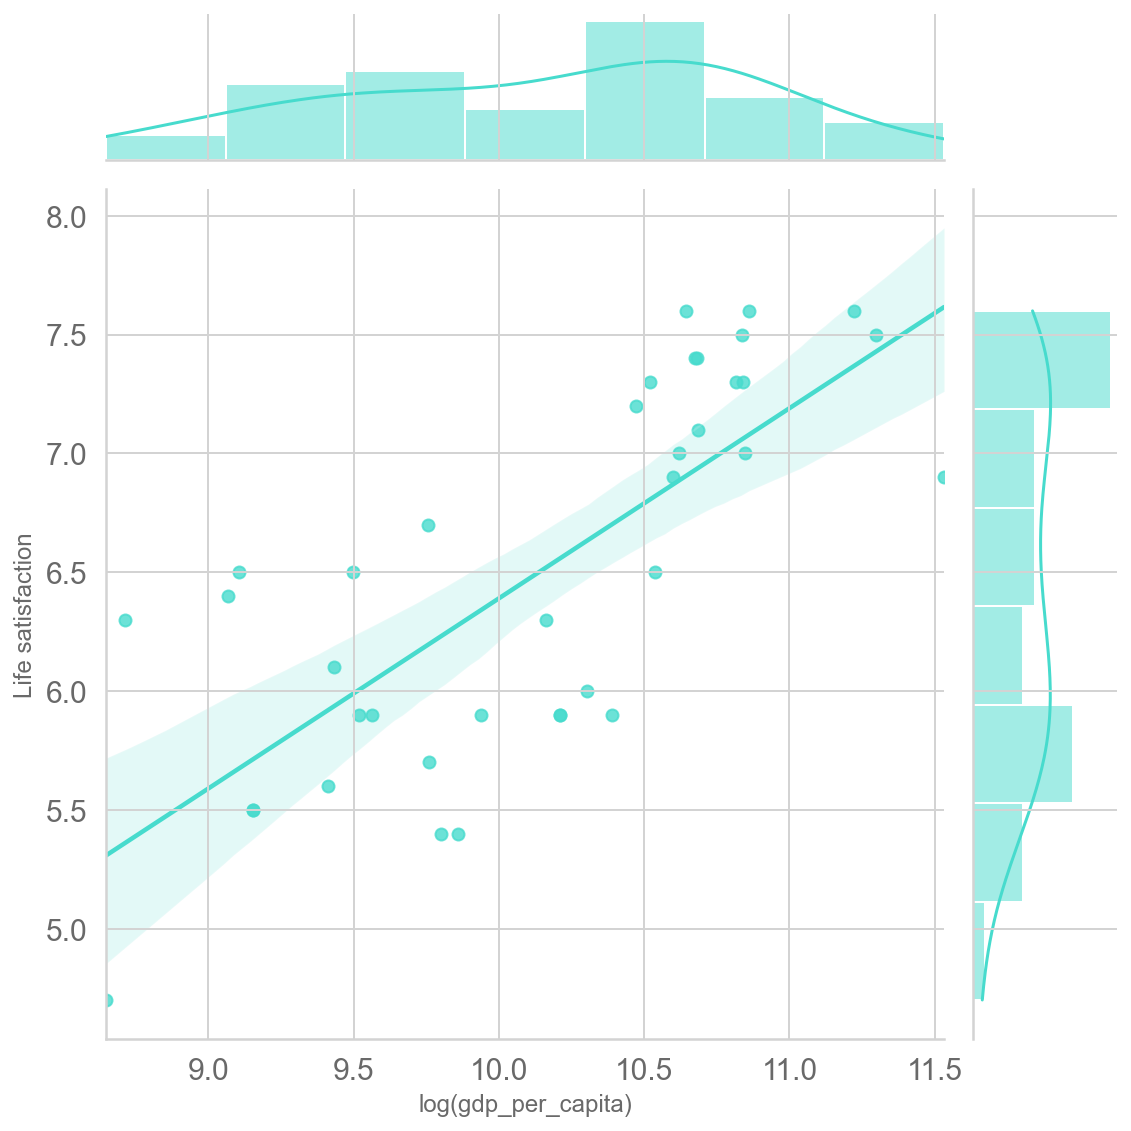

In [35]:
sns.jointplot(x=np.log(df['gdp_per_capita']),
              y=df['Life satisfaction'],
              color="#47DBCD",
              kind="reg",
              height=8)
plt.xlabel("log(gdp_per_capita)");

                                 OLS Regression Results                                
Dep. Variable:      Life satisfaction   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              5824.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):                    2.63e-42
Time:                        19:56:40   Log-Likelihood:                         -29.090
No. Observations:                  38   AIC:                                      60.18
Df Residuals:                      37   BIC:                                      61.82
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

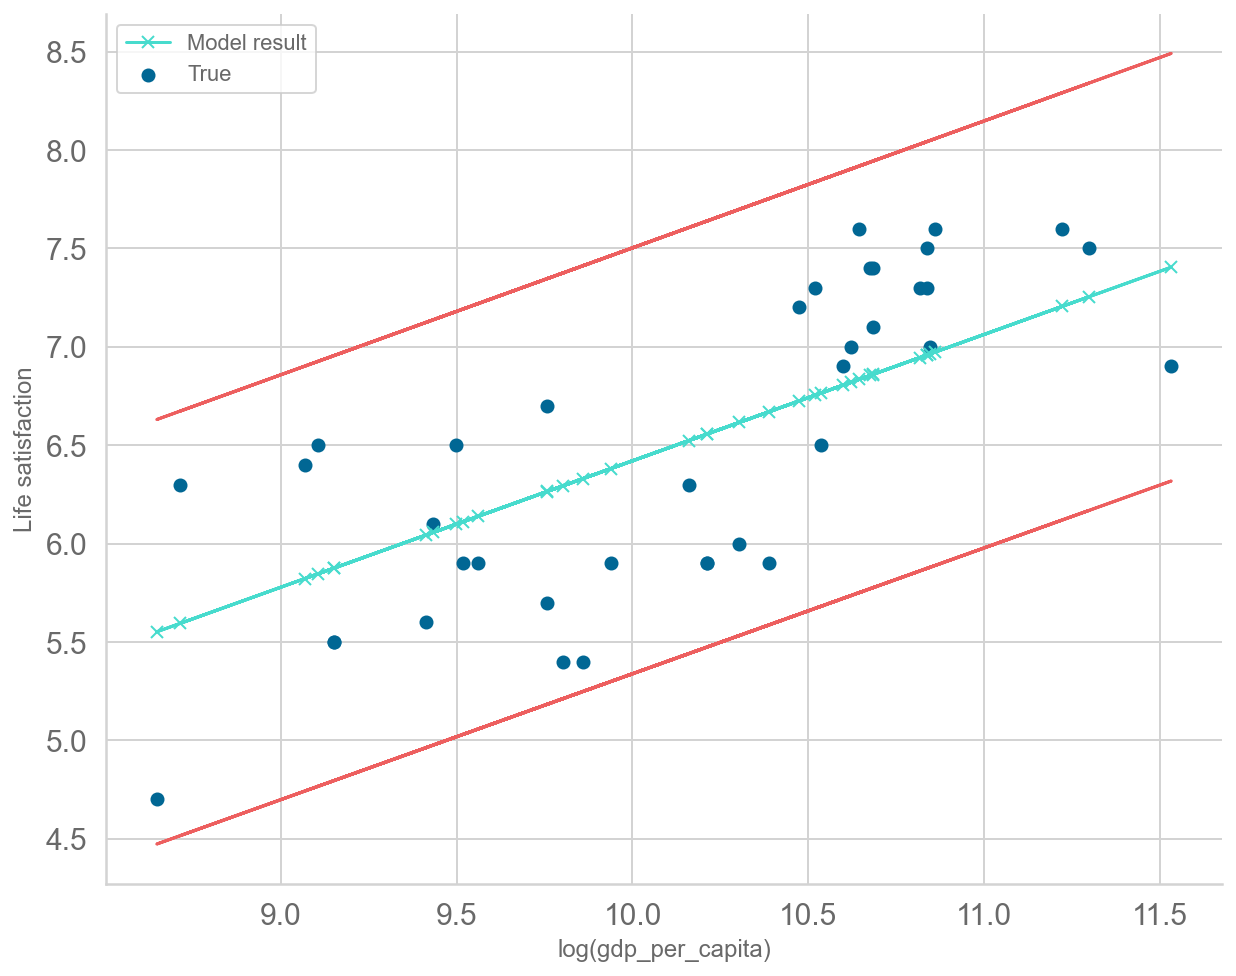

In [36]:
x = np.log(df["gdp_per_capita"])
y = df["Life satisfaction"]

model = sm.OLS(endog=y, exog=x)
results = model.fit()
print(results.summary())

prstd, iv_l, iv_u = wls_prediction_std(results)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(x, results.predict(), marker='x', color="#47DBCD", label="Model result", zorder=10)
ax.scatter(x, y, label="True", color="#016794", zorder=10)

ax.plot(np.log(df["gdp_per_capita"]), iv_u, color="#ED5F5F", zorder=10)
ax.plot(np.log(df["gdp_per_capita"]), iv_l, color="#ED5F5F", zorder=10)

ax.set_xlabel("log(gdp_per_capita)")
ax.set_ylabel("Life satisfaction")
ax.legend(loc='best');

In [37]:
results.params

gdp_per_capita    0.642052
dtype: float64